In [1]:
%load_ext autoreload
%autoreload 2
!hostname
!pwd
import os, sys
print(sys.executable)
# os.environ['CUDA_VISIBLE_DEVICES'] = "4"
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
sys.path.append(os.path.abspath(".."))

slurm0-gpu1nodeset-0
/home/akarsh_sakana_ai/nca-alife/src/science_notebooks
/home/akarsh_sakana_ai/miniconda3/envs/nca-alife-jax/bin/python


In [2]:
import os, sys, glob, pickle
from functools import partial

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from tqdm.auto import tqdm
from einops import rearrange, reduce, repeat

In [3]:
import experiment_utils
import util

# Create Experiment

In [4]:
# group.add_argument("--seed", type=int, default=0)
# group.add_argument("--save_dir", type=str, default=None)

# group = parser.add_argument_group("model")
# group.add_argument("--sim", type=str, default='boids')

# group = parser.add_argument_group("data")
# group.add_argument("--n_rollout_imgs", type=int, default=1)
# group.add_argument("--prompts", type=str, default="an artificial cell,a bacterium")
# group.add_argument("--clip_model", type=str, default="clip-vit-base-patch32") # clip-vit-base-patch32 or clip-vit-large-patch14
# group.add_argument("--coef_prompt", type=float, default=1.)
# group.add_argument("--coef_softmax", type=float, default=0.)
# group.add_argument("--coef_novelty", type=float, default=0.)

# group = parser.add_argument_group("optimization")
# group.add_argument("--bs", type=int, default=1)
# group.add_argument("--pop_size", type=int, default=16)
# group.add_argument("--n_iters", type=int, default=10000)
# group.add_argument("--sigma", type=float, default=1.)

In [5]:
cfg_default = dict(
    seed=0, save_dir=None,
    sim='boids',

    n_rollout_imgs=1,
    prompts="a cell",

    coef_prompt=1., coef_softmax=0., coef_novelty=0.,
    bs=1, pop_size=16,
    n_iters=10000,
    sigma=0.1,
)

seed_sweep = np.arange(4)

with open("./prompts_long.txt", "r") as f:
    prompt_sweep = f.read().strip().split('\n')

sigma = 0.1

# sims_sweep = ['boids', 'dnca', 'lenia', 'nca_d1', 'nca_d3', 'plenia', 'plife_a', 'plife_ba', 'plife_ba_c3']
sims_sweep = ['lenia_1.0', 'boids', 'plife_ba']

cfgs = []
for sim in sims_sweep:
    for seed in seed_sweep:
        for iprt, prompt in enumerate(prompt_sweep):
            cfg = cfg_default.copy()
            cfg.update(sim=sim, seed=seed, prompts=prompt, sigma=sigma)
            cfg.update(save_dir=f"/home/akarsh_sakana_ai/nca-alife-data/main_opt/{seed}_{sim}_{iprt}_{sigma}")
            if sim == 'plife_ba':
                cfg.update(n_iters=1000, pop_size=8)
            cfgs.append(cfg)

print(len(cfgs))

552


In [8]:
commands = experiment_utils.create_commands(cfgs, prefix='python main_opt.py', out_file='../science_scripts/main_opt.sh')
print('\n'.join(commands[:3]), '\n...')
print(len(commands), 'commands')

python main_opt.py --seed=0 --save_dir="/home/akarsh_sakana_ai/nca-alife-data/main_opt/0_lenia_1.0_0_0.1"  --sim="lenia_1.0" --n_rollout_imgs=1 --prompts="a biological cell"                          --coef_prompt=1.0 --coef_softmax=0.0 --coef_novelty=0.0 --bs=1 --pop_size=16 --n_iters=10000 --sigma=0.1
python main_opt.py --seed=0 --save_dir="/home/akarsh_sakana_ai/nca-alife-data/main_opt/0_lenia_1.0_1_0.1"  --sim="lenia_1.0" --n_rollout_imgs=1 --prompts="a biological cell under the microscope"     --coef_prompt=1.0 --coef_softmax=0.0 --coef_novelty=0.0 --bs=1 --pop_size=16 --n_iters=10000 --sigma=0.1
python main_opt.py --seed=0 --save_dir="/home/akarsh_sakana_ai/nca-alife-data/main_opt/0_lenia_1.0_2_0.1"  --sim="lenia_1.0" --n_rollout_imgs=1 --prompts="a bacterium"                                --coef_prompt=1.0 --coef_softmax=0.0 --coef_novelty=0.0 --bs=1 --pop_size=16 --n_iters=10000 --sigma=0.1 
...
552 commands


In [6]:
cfg_default = dict(
    seed=0, save_dir=None,
    sim='plife_ba',

    n_rollout_imgs=1,
    prompts="a cell",

    coef_prompt=1., coef_softmax=0., coef_novelty=0.,
    bs=1, pop_size=16,
    n_iters=10000,
    sigma=0.1,
)

seed_sweep = np.arange(4)

with open("./prompts_long.txt", "r") as f:
    prompt_sweep = f.read().strip().split('\n')

sigma = 0.1

# sims_sweep = ['boids', 'dnca', 'lenia', 'nca_d1', 'nca_d3', 'plenia', 'plife_a', 'plife_ba', 'plife_ba_c3']
sims_sweep = ['lenia_1.0', 'boids', 'plife_ba']

cfgs_plife_sweep = []
for seed in seed_sweep:
    for n in [30, 100, 300, 1000, 3000, 10000]:
        for k in [1, 2, 3, 4, 5, 6]:
            cfg = cfg_default.copy()
            sim = f'plife_ba;n={n};k={k}'
            cfg.update(sim=sim, seed=seed, prompts="a caterpillar", sigma=sigma)
            cfg.update(save_dir=f"/home/akarsh_sakana_ai/nca-alife-data/main_opt_plife_n_sweep/{seed}_{sim}_{sigma}")
            cfg.update(n_iters=1000, pop_size=8)
            cfgs_plife_sweep.append(cfg)
print(len(cfgs_plife_sweep))

144


In [10]:
commands = experiment_utils.create_commands(cfgs_plife_sweep, prefix='python main_opt.py', out_file='../science_scripts/main_opt_plife_n_sweep.sh')
print('\n'.join(commands[:3]), '\n...')
print(len(commands), 'commands')

python main_opt.py --seed=0 --save_dir="/home/akarsh_sakana_ai/nca-alife-data/main_opt_plife_n_sweep/0_plife_ba;n=30;k=1_0.1"    --sim="plife_ba;n=30;k=1"    --n_rollout_imgs=1 --prompts="a caterpillar" --coef_prompt=1.0 --coef_softmax=0.0 --coef_novelty=0.0 --bs=1 --pop_size=8 --n_iters=1000 --sigma=0.1
python main_opt.py --seed=0 --save_dir="/home/akarsh_sakana_ai/nca-alife-data/main_opt_plife_n_sweep/0_plife_ba;n=30;k=2_0.1"    --sim="plife_ba;n=30;k=2"    --n_rollout_imgs=1 --prompts="a caterpillar" --coef_prompt=1.0 --coef_softmax=0.0 --coef_novelty=0.0 --bs=1 --pop_size=8 --n_iters=1000 --sigma=0.1
python main_opt.py --seed=0 --save_dir="/home/akarsh_sakana_ai/nca-alife-data/main_opt_plife_n_sweep/0_plife_ba;n=30;k=3_0.1"    --sim="plife_ba;n=30;k=3"    --n_rollout_imgs=1 --prompts="a caterpillar" --coef_prompt=1.0 --coef_softmax=0.0 --coef_novelty=0.0 --bs=1 --pop_size=8 --n_iters=1000 --sigma=0.1 
...
144 commands


# Visualize Results

In [7]:
from matplotlib import font_manager
font_files = font_manager.findSystemFonts(fontpaths=["/home/akarsh_sakana_ai/nca-alife/fonts"])
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
plt.rcParams['font.family'] = 'Go'
plt.rcParams['font.sans-serif'] = ['Go']
plt.rcParams['font.serif'] = ['Go']
plt.rcParams['font.monospace'] = ['Go Mono']

In [8]:
import jax
import jax.numpy as jnp
import copy
from create_sim import create_sim, FlattenSimulationParameters, rollout_and_embed_simulation, rollout_simulation

In [9]:
a = []
for cfg in tqdm(cfgs):
    save_dir = cfg['save_dir']
    a.append(util.load_pkl(save_dir, "data")['best_loss'])
a = [np.array(a[:184]), np.array(a[184:184*2]), np.array(a[184*2:])]

  0%|          | 0/552 [00:00<?, ?it/s]

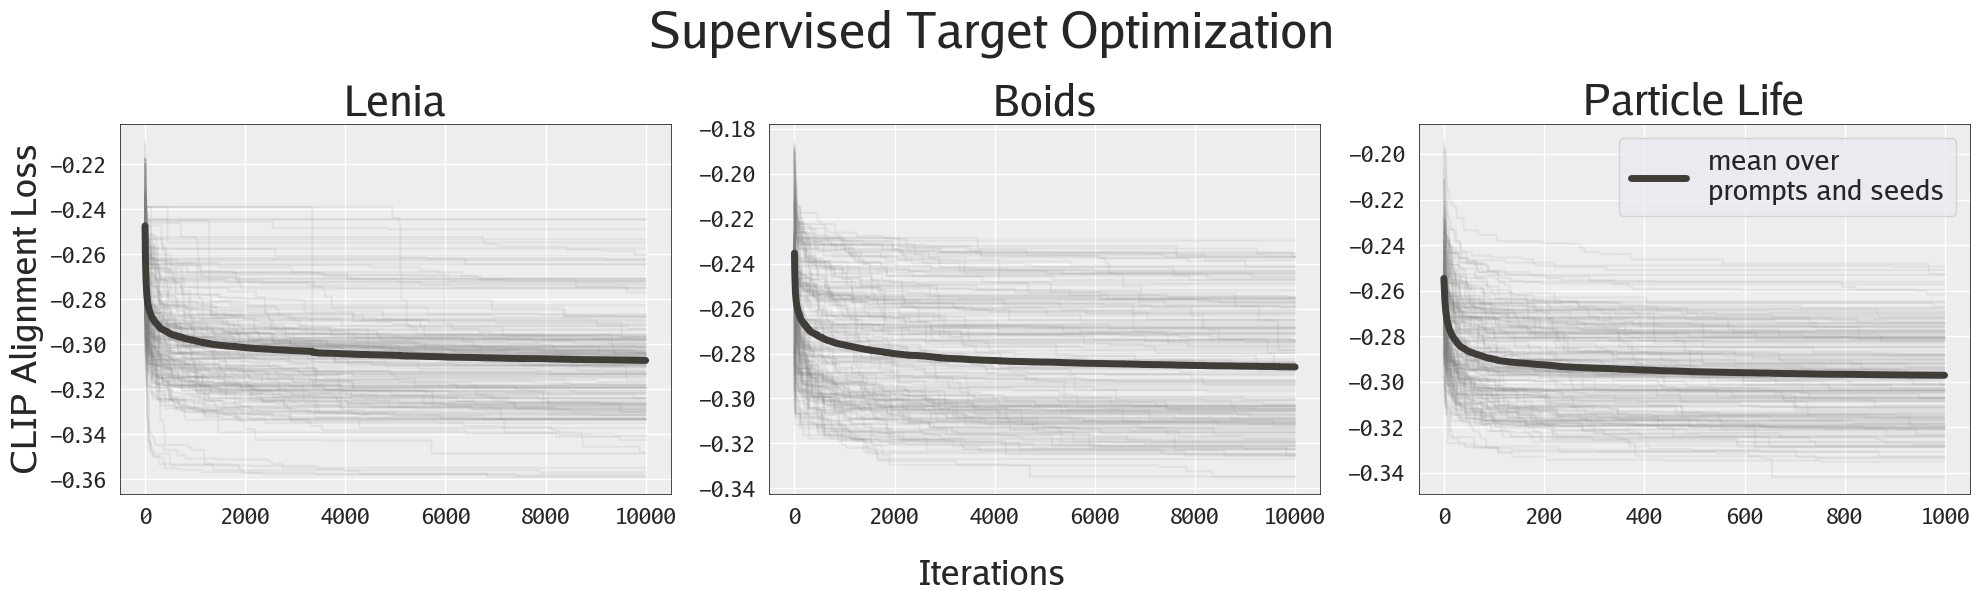

In [37]:
plt.figure(figsize=(20, 6))

for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.plot(a[i].T, c='gray', alpha=0.1)
    plt.plot(a[i].mean(axis=0), c='#403d39', alpha=1.0, linewidth=5, label='mean over\nprompts and seeds');
    plt.xticks(fontsize=16); plt.yticks(fontsize=16);
    if i==0:
        plt.ylabel("CLIP Alignment Loss", fontsize=25)
        plt.title("Lenia", fontsize=30)
    if i==1:
        plt.title("Boids", fontsize=30)
    if i==2:
        plt.title("Particle Life", fontsize=30)
    if i==2:
        plt.legend(fontsize=20)
    
    plt.gca().set_facecolor("#ededed")
    plt.grid(color='white')
    [plt.gca().spines[i].set_color('black') for i in ['top', 'bottom', 'left', 'right']]
    [plt.gca().spines[i].set_linewidth(0.5) for i in ['top', 'bottom', 'left', 'right']]

plt.gcf().supxlabel("Iterations", fontsize=25)
plt.suptitle("Supervised Target Optimization", fontsize=35)
plt.tight_layout()
plt.savefig("/home/akarsh_sakana_ai/nca-alife-data/figs_final/supervised_learning_curve.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.savefig("/home/akarsh_sakana_ai/nca-alife-data/figs_final/supervised_learning_curve.png", format='png', dpi=300, bbox_inches='tight')

In [10]:
df = []

for cfg in tqdm(cfgs):
    try:
        save_dir = cfg['save_dir']
        dfi = copy.copy(cfg)
        iprt = prompt_sweep.index(cfg['prompts'])
        dfi.update(iprt=iprt)
        # data = util.load_pkl(save_dir, "data")
        # dfi['best_loss'] = data['best_loss'][-50:].mean()
        # dfi.update({k: v[-50:].max(axis=-1).mean().item() for k, v in data['loss_dict'].items()})
        params, loss = util.load_pkl(save_dir, "best")
        dfi['loss'] = loss.item()
        dfi['params'] = params
        df.append(dfi)
    except Exception as e:
        print(e)
        break
df = pd.DataFrame(df)

  0%|          | 0/552 [00:00<?, ?it/s]

In [11]:
df

seed                                           save_dir        sim  \
0       0  /home/akarsh_sakana_ai/nca-alife-data/main_opt...  lenia_1.0   
1       0  /home/akarsh_sakana_ai/nca-alife-data/main_opt...  lenia_1.0   
2       0  /home/akarsh_sakana_ai/nca-alife-data/main_opt...  lenia_1.0   
3       0  /home/akarsh_sakana_ai/nca-alife-data/main_opt...  lenia_1.0   
4       0  /home/akarsh_sakana_ai/nca-alife-data/main_opt...  lenia_1.0   
..    ...                                                ...        ...   
547     3  /home/akarsh_sakana_ai/nca-alife-data/main_opt...   plife_ba   
548     3  /home/akarsh_sakana_ai/nca-alife-data/main_opt...   plife_ba   
549     3  /home/akarsh_sakana_ai/nca-alife-data/main_opt...   plife_ba   
550     3  /home/akarsh_sakana_ai/nca-alife-data/main_opt...   plife_ba   
551     3  /home/akarsh_sakana_ai/nca-alife-data/main_opt...   plife_ba   

     n_rollout_imgs                                     prompts  coef_prompt  \
0                 1                           a biological cell          1.0   
1                 1      a biological cell under the microscope          1.0   
2                 1                                 a bacterium          1.0   
3                 1                             bacteria colony          1.0   
4                 1  a diverse ecosystem of cells moving around          1.0   
..              ...                                         ...          ...   
547               1               an artificial life simulation          1.0   
548               1                           an alien organism          1.0   
549               1                                     a plant          1.0   
550               1                        a web-like structure          1.0   
551               1                                  slime mold          1.0   

     coef_softmax  coef_novelty  bs  pop_size  n_iters  sigma  iprt      loss  \
0             0.0           0.0   1        16    10000    0.1     0 -0.324088   
1             0.0           0.0   1        16    10000    0.1     1 -0.300681   
2             0.0           0.0   1        16    10000    0.1     2 -0.333593   
3             0.0           0.0   1        16    10000    0.1     3 -0.293008   
4             0.0           0.0   1        16    10000    0.1     4 -0.302713   
..            ...           ...  ..       ...      ...    ...   ...       ...   
547           0.0           0.0   1         8     1000    0.1    41 -0.293589   
548           0.0           0.0   1         8     1000    0.1    42 -0.307275   
549           0.0           0.0   1         8     1000    0.1    43 -0.272759   
550           0.0           0.0   1         8     1000    0.1    44 -0.273846   
551           0.0           0.0   1         8     1000    0.1    45 -0.264747   

                                                params  
0    [1.9191935, 1.2279437, -1.0010641, 1.3763195, ...  
1    [-1.9731351, -0.3904606, -0.8175611, -3.207666...  
2    [0.16983324, -0.22019659, -0.074828066, 0.0382...  
3    [-3.6446006, 0.7537294, -3.1274424, -0.9758600...  
4    [2.4171107, -4.4733863, -0.2423386, -4.822434,...  
..                                                 ...  
547  [-0.4963871, 2.0361605, -0.07376192, -1.319295...  
548  [-0.52268356, -0.14605597, -0.27630678, 0.1403...  
549  [-0.04293208, -1.3378688, 0.99614704, -0.56700...  
550  [-0.015150253, 0.20970698, 0.52450734, -0.3951...  
551  [-0.19216025, -0.149993, 0.4404225, -0.2498062...  

[552 rows x 15 columns]

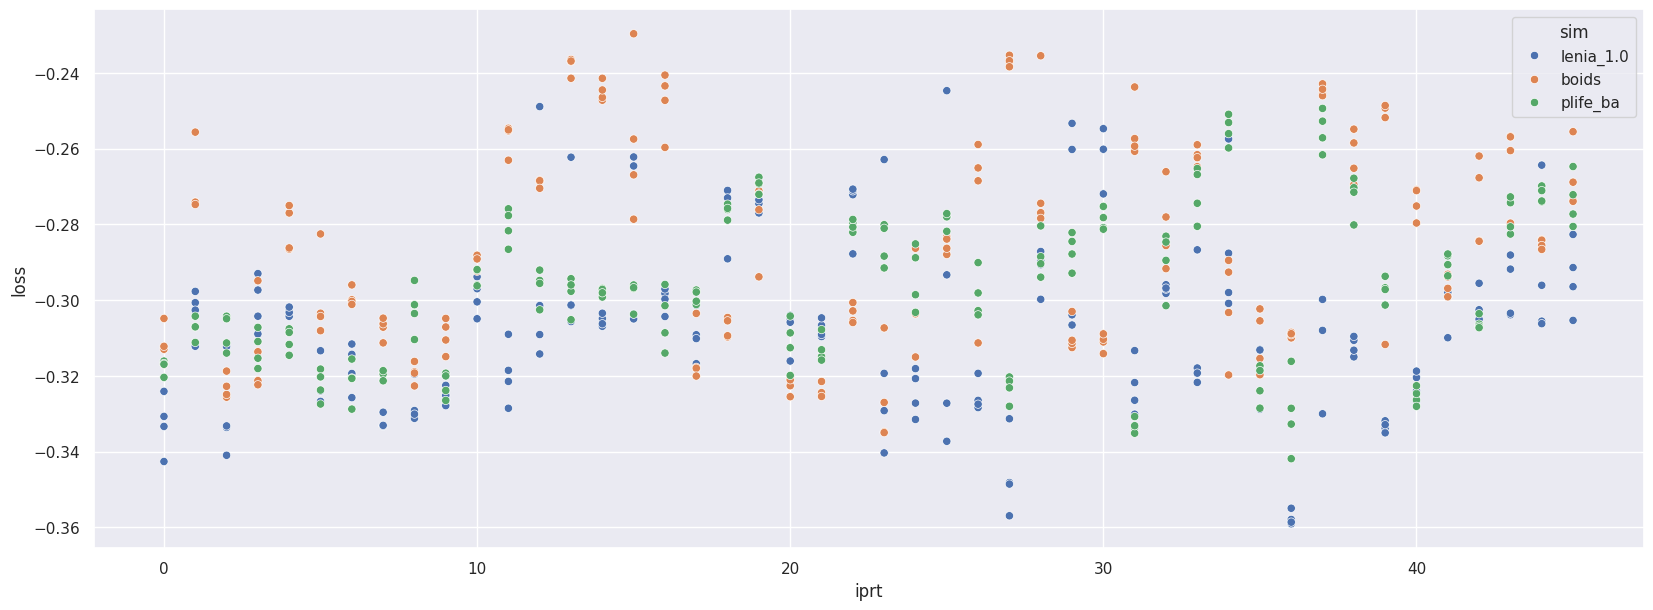

In [15]:
plt.figure(figsize=(20, 7))
sns.scatterplot(data=df, x='iprt', y='loss', hue='sim')
plt.show()

ParameterReshaper: 3117 parameters detected for optimization.


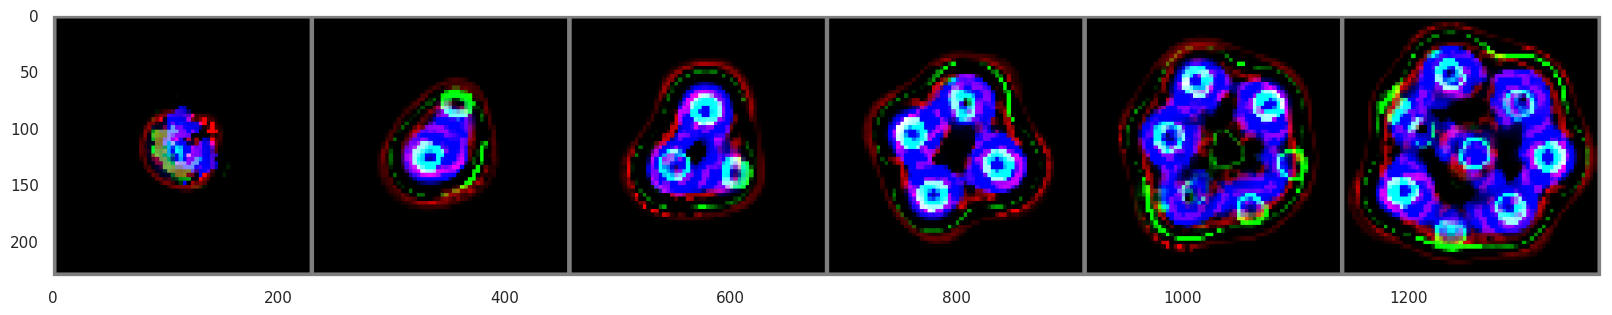

In [ ]:
rng = jax.random.PRNGKey(0)
sim_name = sims_sweep[0]
sim = create_sim(sim_name)
sim = FlattenSimulationParameters(sim)
rollout_fn = partial(rollout_and_embed_simulation, sim=sim, clip_model=None, rollout_steps=252, n_rollout_imgs=6)
rollout_fn = jax.jit(rollout_fn)
iprt = 1
dfi = df[(df.sim==sim_name) & (df.iprt==iprt)]
dfi = dfi.loc[dfi['loss'].idxmin()]
rollout_data = rollout_fn(rng, dfi['params'])
img = rollout_data['rgb']
img = jnp.pad(img, ((0, 0), (4, 0), (4, 0), (0, 0)), mode='constant', constant_values=0.5)
img = rearrange(img, "T H W D -> H (T W) D")
img = jnp.pad(img, ((0, 4), (0, 4), (0, 0)), mode='constant', constant_values=0.5)

plt.figure(figsize=(20, 5))
plt.imshow(img)
plt.grid(False)
plt.show()

plt.imsave("/home/akarsh_sakana_ai/nca-alife-data/figs/teaser_supervised.png", img)

ParameterReshaper: 3117 parameters detected for optimization.


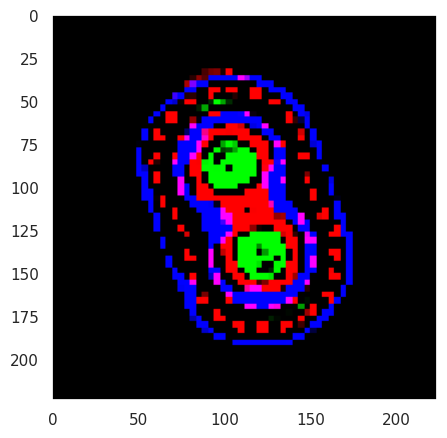

In [41]:
rng = jax.random.PRNGKey(0)
sim_name = sims_sweep[0]
sim = create_sim(sim_name)
sim = FlattenSimulationParameters(sim)
rollout_fn = partial(rollout_and_embed_simulation, sim=sim, clip_model=None, rollout_steps=sim.sim.rollout_steps, n_rollout_imgs='final')
rollout_fn = jax.jit(rollout_fn)
iprt = 0
dfi = df[(df.sim==sim_name) & (df.iprt==iprt)]
dfi = dfi.loc[dfi['loss'].idxmin()]
rollout_data = rollout_fn(rng, dfi['params'])
img = rollout_data['rgb']

plt.figure(figsize=(20, 5))
plt.imshow(img)
plt.grid(False)
plt.show()

plt.imsave("/home/akarsh_sakana_ai/nca-alife-data/figs_final/teaser_microscope.png", img)

In [12]:
def get_sliding_img(vid, t, n_frames):
    T, H, W, D = vid.shape
    if t > T-1:
        t = T-1
    assert T%n_frames==0
    full_img = np.zeros((H, W*n_frames, D))
    k = T // n_frames
    for i in range(int(t/k)+1):
        img = vid[k*i]
        full_img[:, W*i:W*(i+1), :] = img
    fx = W*n_frames
    x = int(t/T * fx)
    if x+W < fx:
        full_img[:, x:x+W, :] = vid[t]
    return full_img

In [13]:
rng = jax.random.PRNGKey(0)
sim_name = sims_sweep[0]
sim = create_sim(sim_name)
sim = FlattenSimulationParameters(sim)
rollout_fn = partial(rollout_and_embed_simulation, sim=sim, clip_model=None, rollout_steps=sim.sim.rollout_steps, n_rollout_imgs='video')
rollout_fn = jax.jit(rollout_fn)
iprt = 1
dfi = df[(df.sim==sim_name) & (df.iprt==iprt)]
dfi = dfi.loc[dfi['loss'].idxmin()]
rollout_data = rollout_fn(rng, dfi['params'])
vid = rollout_data['rgb'][:252:2]

sliding_vid = []
for t in tqdm(range(len(vid))):
    img = get_sliding_img(np.pad(vid, ((0, 0), (1, 1), (1, 1), (0, 0)), mode='constant', constant_values=0.5), t, n_frames=6)
    img = np.pad(img, ((1, 1), (1, 1), (0, 0)), mode='constant', constant_values=0.5)
    sliding_vid.append(img)
sliding_vid = np.stack(sliding_vid)

plt.imsave("/home/akarsh_sakana_ai/nca-alife-data/figs_final/teaser_supervised.png", sliding_vid[-1])

import imageio
sliding_vid = np.array(sliding_vid*255, dtype=np.uint8)
imageio.mimwrite("/home/akarsh_sakana_ai/nca-alife-data/figs_final/teaser_supervised.mp4", sliding_vid, fps=21)

2024-12-21 03:56:08.668993: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.6.68). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


ParameterReshaper: 3117 parameters detected for optimization.


  0%|          | 0/126 [00:00<?, ?it/s]

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1358, 228) to (1360, 240) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
/home/akarsh_sakana_ai/miniconda3/envs/nca-alife-jax/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
[swscaler @ 0x5993f00] Warning: data is not aligned! This can lead to a speed loss


In [16]:
rng = jax.random.PRNGKey(0)
imgs = []
for sim_name in sims_sweep:
    sim = create_sim(sim_name)
    sim = FlattenSimulationParameters(sim)
    rollout_fn = partial(rollout_and_embed_simulation, sim=sim, clip_model=None, rollout_steps=sim.sim.rollout_steps, n_rollout_imgs='final')
    rollout_fn = jax.jit(rollout_fn)
    for iprt, prompt in enumerate(tqdm(prompt_sweep)):
        dfi = df[(df.sim==sim_name) & (df.iprt==iprt)]
        dfi = dfi.loc[dfi['loss'].idxmin()]
        rollout_data = rollout_fn(rng, dfi['params'])
        imgs.append(rollout_data['rgb'])
imgs = jnp.stack(imgs).reshape(len(sims_sweep), len(prompt_sweep), 224, 224, 3)
print(imgs.shape)

ParameterReshaper: 3117 parameters detected for optimization.


  0%|          | 0/46 [00:00<?, ?it/s]

ParameterReshaper: 193 parameters detected for optimization.


  0%|          | 0/46 [00:00<?, ?it/s]

ParameterReshaper: 42 parameters detected for optimization.


  0%|          | 0/46 [00:00<?, ?it/s]

(3, 46, 224, 224, 3)


In [17]:
# plt.imshow(imgs[0, 9])
plt.imsave("/home/akarsh_sakana_ai/nca-alife-data/figs_final/methods_example_1.png", imgs[0, 3])
plt.imsave("/home/akarsh_sakana_ai/nca-alife-data/figs_final/methods_example_2.png", imgs[0, 19])
plt.imsave("/home/akarsh_sakana_ai/nca-alife-data/figs_final/methods_example_3.png", imgs[0, 40])
# plt.show()

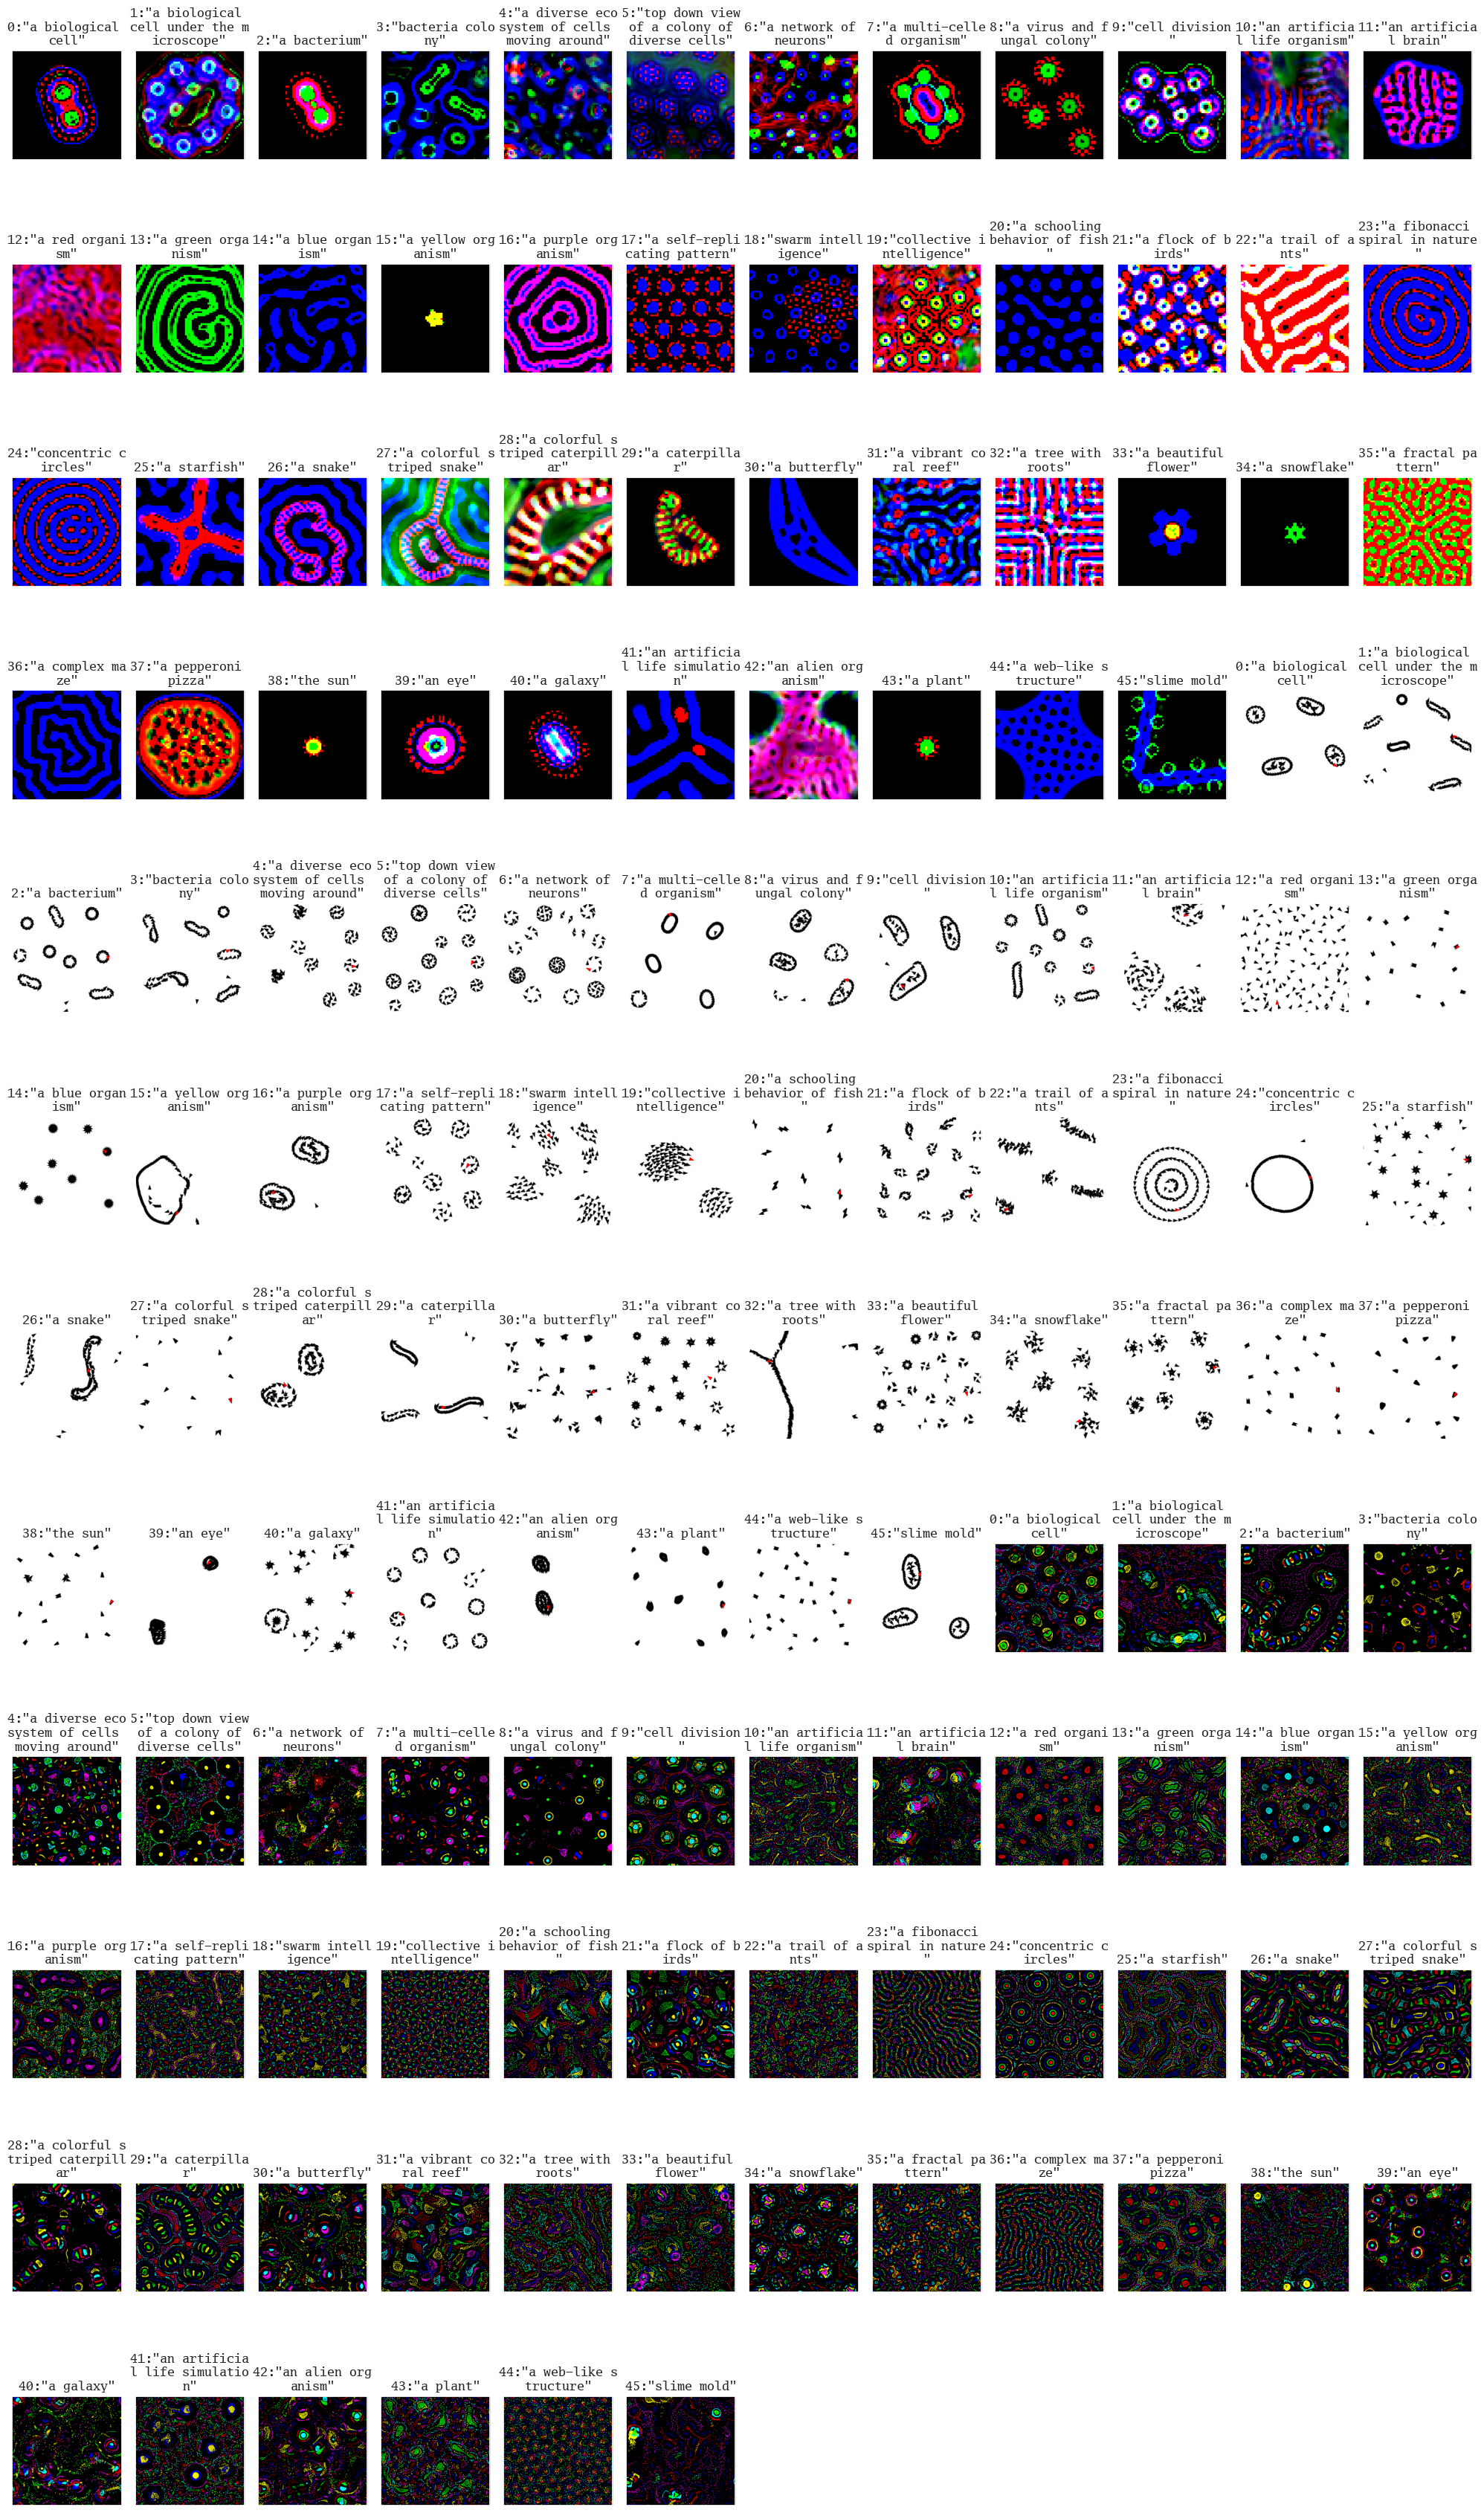

In [12]:
def wrap_str(s, n):
    return "\n".join([s[i:i+n] for i in range(0, len(s), n)])

plt.figure(figsize=(20, 35))
iplt = 0
for i_sim, sim_name in enumerate(sims_sweep):
    for iprt, prompt in enumerate(prompt_sweep):
        img = imgs[i_sim, iprt]
        iplt += 1
        plt.subplot(12, 12, iplt)
        plt.imshow(img)
        plt.xticks([]); plt.yticks([])
        plt.title(wrap_str(f"{iprt}:\"{prompt}\"", 16), fontname='monospace', fontsize=12)

plt.tight_layout()
plt.show()



In [17]:
def wrap_str(s, n):
    words = s.split()
    lines = []
    current_line = []
    current_length = 0

    for word in words:
        if current_length + len(word) + len(current_line) > n:
            lines.append(' '.join(current_line))
            current_line = [word]
            current_length = len(word)
        else:
            current_line.append(word)
            current_length += len(word)

    if current_line:
        lines.append(' '.join(current_line))

    return '\n'.join(lines)

In [26]:
for i_sim, sim_name in enumerate(sims_sweep):
    # plt.figure(figsize=(20, 15))
    # plt.figure(figsize=(15, 16))
    plt.figure(figsize=(20, 28))
    iplt = 0
    for iprt, prompt in enumerate(prompt_sweep):
        img = imgs[i_sim, iprt]
        img = np.pad(img, ((4, 4), (4, 4), (0, 0)), mode='constant', constant_values=0.5)
        iplt += 1
        plt.subplot(7, 7, iplt)
        plt.imshow(img)
        plt.xticks([]); plt.yticks([])
        plt.title(wrap_str(f"\"{prompt}\"", 17), fontname='Go Mono', fontsize=20)

    title = "Lenia" if i_sim == 0 else "Boids" if i_sim == 1 else "Particle Life"
    print(title)
    plt.suptitle(f"Extra Supervised Target in {title}", fontname="Go", fontsize=35, y=1.005)
    plt.tight_layout()
    plt.savefig(f"/home/akarsh_sakana_ai/nca-alife-data/figs_final/supervised_extra_{i_sim}.pdf", format='pdf', dpi=300, bbox_inches='tight')
    plt.savefig(f"/home/akarsh_sakana_ai/nca-alife-data/figs_final/supervised_extra_{i_sim}.png", format='png', dpi=300, bbox_inches='tight')
    plt.close()
    # break

Lenia
Boids
Particle Life


In [13]:
sim_iprts = [[0, 6, 7, 8, 11, 17, 29, 33, 37, 39], [0, 17, 19, 22, 23, 25, 26, 32, 35, 40], [1, 4, 6, 9, 12, 16, 17, 24, 27, 29]]

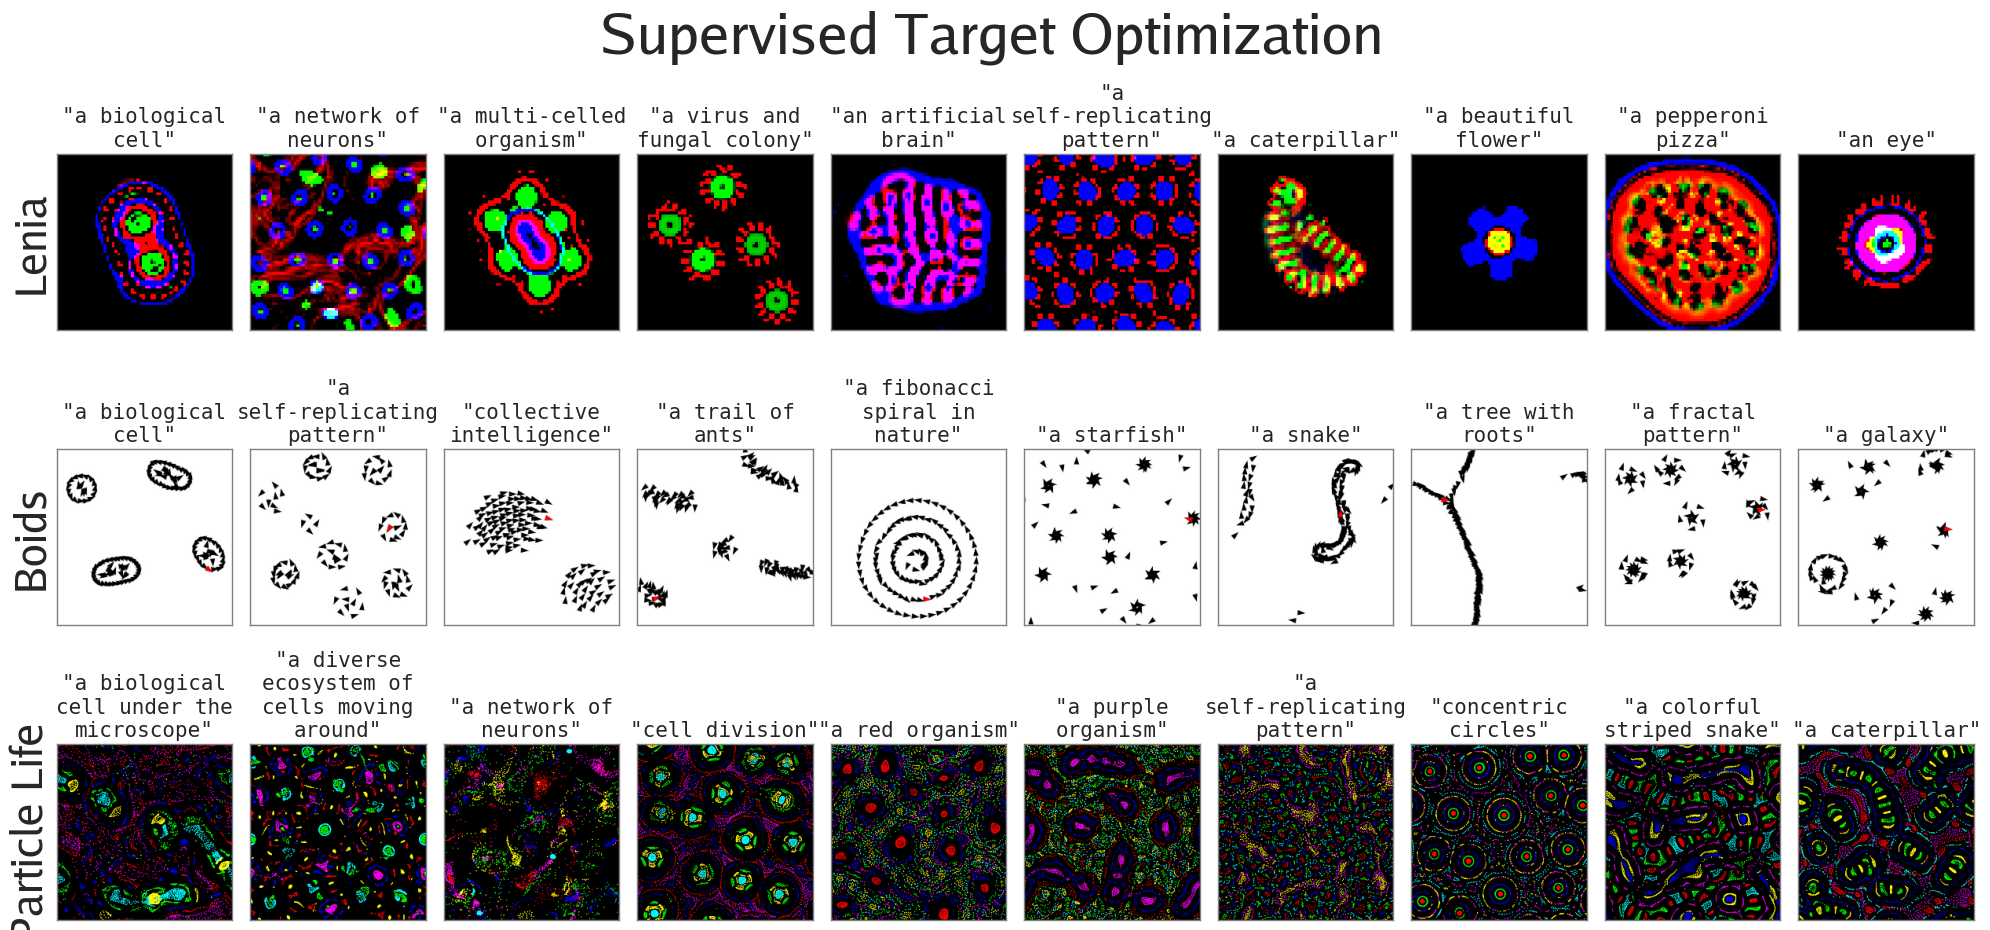

In [ ]:

# plt.figure(figsize=(20, 10))
fig, axs = plt.subplots(3, 10, figsize=(20, 10))
# fig, axs = plt.subplots(6, 5, figsize=(20, 30))
iplt = 0
for i_sim, sim_name in enumerate(sims_sweep):
    for i, iprt in enumerate(sim_iprts[i_sim]):
        prompt = prompt_sweep[iprt]
        img = imgs[i_sim, iprt]

        plt.sca(axs.flatten()[iplt])
        plt.imshow(img)
        plt.xticks([]); plt.yticks([])
        plt.title(wrap_str(f"\"{prompt}\"", 16), fontname='monospace', fontsize=15)
        iplt += 1

        for spine in plt.gca().spines.values():
            spine.set_edgecolor((0.5, 0.5, 0.5, 1.))
            spine.set_linewidth(1)
    
axs[0, 0].set_ylabel("Lenia", fontsize=30, fontname='Go')
axs[1, 0].set_ylabel("Boids", fontsize=30, fontname='Go')
axs[2, 0].set_ylabel("Particle Life", fontsize=30, fontname='Go')

plt.suptitle("Supervised Target Optimization", fontsize=40, fontname='Go')
plt.tight_layout()

plt.savefig("/home/akarsh_sakana_ai/nca-alife-data/figs/supervised_3x10.png", dpi=300)
plt.show()



In [ ]:
# plt.figure(figsize=(20, 10))
# fig, axs = plt.subplots(3, 10, figsize=(20, 10))
fig, axs = plt.subplots(6, 5, figsize=(20, 30))
iplt = 0
for i_sim, sim_name in enumerate(sims_sweep):
    for i, iprt in enumerate(sim_iprts[i_sim]):
        prompt = prompt_sweep[iprt]
        img = imgs[i_sim, iprt]

        plt.sca(axs.flatten()[iplt])
        plt.imshow(img)
        plt.xticks([]); plt.yticks([])
        plt.title(wrap_str(f"\"{prompt}\"", 25), fontname='monospace', fontsize=18)

        for spine in plt.gca().spines.values():
            spine.set_edgecolor((0.5, 0.5, 0.5, 1.))
            spine.set_linewidth(1)
        iplt += 1
    
# axs[0, 0].set_ylabel("Lenia", fontsize=30, fontname='Go')
# axs[1, 0].set_ylabel("Boids", fontsize=30, fontname='Go')
# axs[2, 0].set_ylabel("Particle Life", fontsize=30, fontname='Go')

fig.text(-0.01, 0.81, 'Lenia', va='center', ha='center', rotation=90, fontsize=35, fontname='Go')
fig.text(-0.01, 0.49, 'Boids', va='center', ha='center', rotation=90, fontsize=35, fontname='Go')
fig.text(-0.01, 0.16, 'Particle Life', va='center', ha='center', rotation=90, fontsize=35, fontname='Go')


plt.suptitle("Supervised Target Optimization", y=1.000, fontsize=40, fontname='Go')
plt.tight_layout()

plt.savefig("/home/akarsh_sakana_ai/nca-alife-data/figs/supervised_6x5.png", dpi=300)
plt.show()



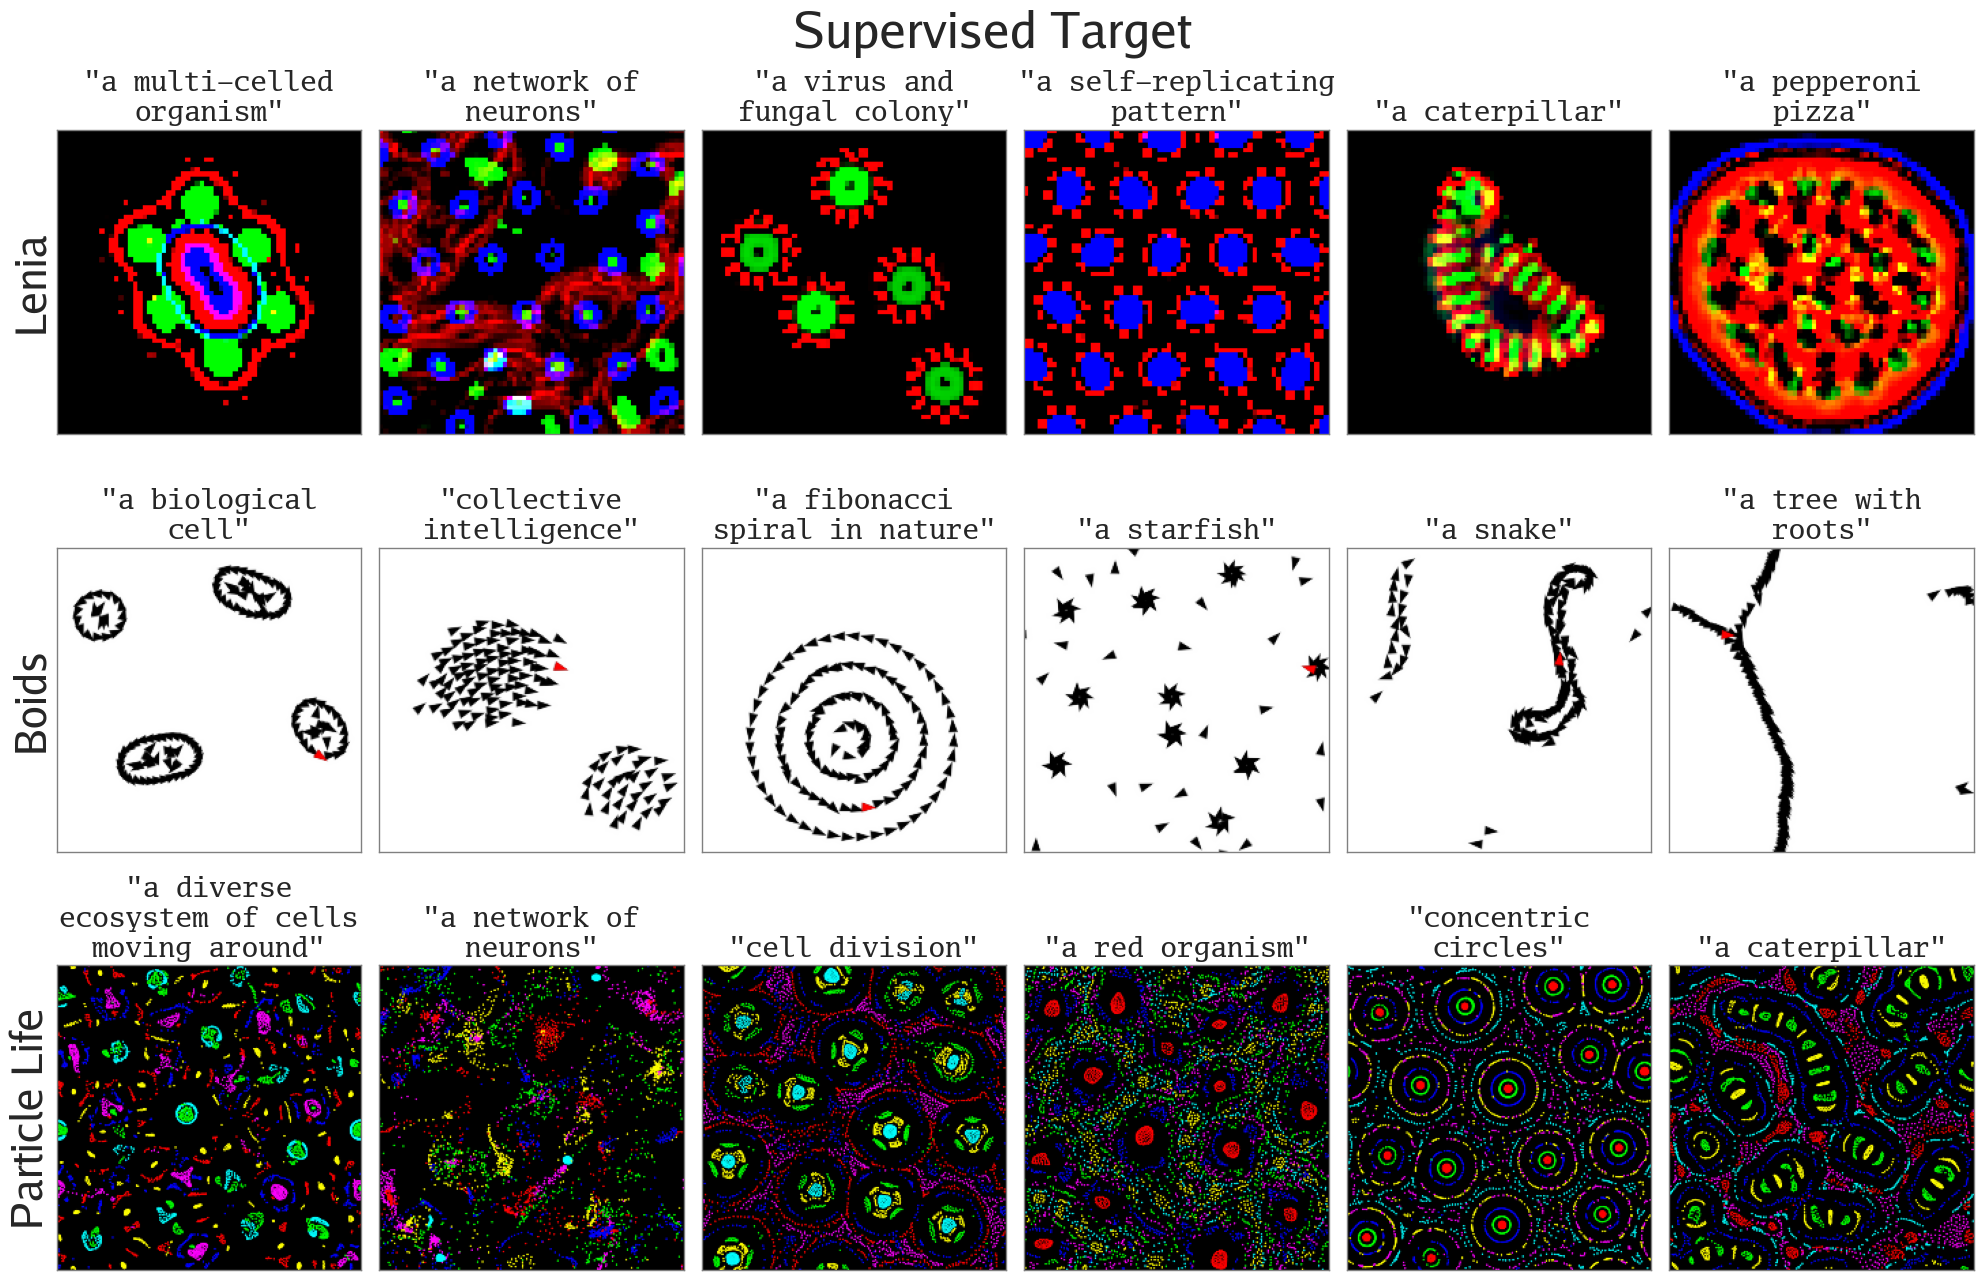

In [18]:
# plt.figure(figsize=(20, 10))
# sim_iprts = [[0, 6, 7, 8, 17, 29, 33, 37], [0, 19, 22, 23, 25, 26, 32, 35], [4, 6, 9, 12, 17, 24, 27, 29]]
# fig, axs = plt.subplots(3, 8, figsize=(20, 12))
sim_iprts = [[7, 6, 8, 17, 29, 37], [0, 19, 23, 25, 26, 32], [4, 6, 9, 12, 24, 29]]
fig, axs = plt.subplots(3, 6, figsize=(20, 13.5))
iplt = 0
for i_sim, sim_name in enumerate(sims_sweep):
    for i, iprt in enumerate(sim_iprts[i_sim]):
        prompt = prompt_sweep[iprt]
        img = imgs[i_sim, iprt]

        plt.sca(axs.flatten()[iplt])
        plt.imshow(img)
        plt.xticks([]); plt.yticks([])
        plt.title(wrap_str(f"\"{prompt}\"", 18), fontname='Go Mono', fontsize=20)
        if i==3:
            plt.title(wrap_str(f"\"{prompt}\"", 20), fontname='Go Mono', fontsize=20)
        iplt += 1

        for spine in plt.gca().spines.values():
            spine.set_edgecolor((0.5, 0.5, 0.5, 1.))
            spine.set_linewidth(1)
    
axs[0, 0].set_ylabel("Lenia", fontsize=30, fontname='Go')
axs[1, 0].set_ylabel("Boids", fontsize=30, fontname='Go')
axs[2, 0].set_ylabel("Particle Life", fontsize=30, fontname='Go')
plt.suptitle("Supervised Target", fontsize=35, fontname='Go')
plt.tight_layout()

plt.savefig("/home/akarsh_sakana_ai/nca-alife-data/figs_final/supervised_3x6.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.savefig("/home/akarsh_sakana_ai/nca-alife-data/figs_final/supervised_3x6.png", format='png', dpi=300, bbox_inches='tight')
plt.show()


In [19]:
rng = jax.random.PRNGKey(0)
vids = []
for i_sim, sim_name in enumerate(sims_sweep):
    # i_sim = 0
    # sim_name = 'lenia_1.0'
    print(sim_name)
    sim = create_sim(sim_name)
    sim = FlattenSimulationParameters(sim)

    if sim_name == 'lenia_1.0':
        rollout_steps, n_rollout_imgs = 256, 256
    elif sim_name == 'boids':
        rollout_steps, n_rollout_imgs = 1024, 1024
    elif sim_name == 'plife_ba':
        rollout_steps, n_rollout_imgs = 1024, 1024
    rollout_fn = partial(rollout_and_embed_simulation, sim=sim, clip_model=None, rollout_steps=rollout_steps, n_rollout_imgs=n_rollout_imgs)
    rollout_fn = jax.jit(rollout_fn)

    for iprt in tqdm(sim_iprts[i_sim]):
        prompt = prompt_sweep[iprt]
        dfi = df[(df.sim==sim_name) & (df.iprt==iprt)]
        dfi = dfi.loc[dfi['loss'].idxmin()]
        rollout_data = rollout_fn(rng, dfi['params'])
        print(rollout_data['rgb'].shape)
        vids.append(rollout_data['rgb'])
# vids = [jax.image.resize(vid, (256, 224, 224, 3), method='bilinear') for vid in tqdm(vids)]

lenia_1.0
ParameterReshaper: 3117 parameters detected for optimization.


  0%|          | 0/6 [00:00<?, ?it/s]

(256, 224, 224, 3)
(256, 224, 224, 3)
(256, 224, 224, 3)
(256, 224, 224, 3)
(256, 224, 224, 3)
(256, 224, 224, 3)
boids
ParameterReshaper: 193 parameters detected for optimization.


  0%|          | 0/6 [00:00<?, ?it/s]

(1024, 224, 224, 3)
(1024, 224, 224, 3)
(1024, 224, 224, 3)
(1024, 224, 224, 3)
(1024, 224, 224, 3)
(1024, 224, 224, 3)
plife_ba
ParameterReshaper: 42 parameters detected for optimization.


  0%|          | 0/6 [00:00<?, ?it/s]

(1024, 224, 224, 3)
(1024, 224, 224, 3)
(1024, 224, 224, 3)
(1024, 224, 224, 3)
(1024, 224, 224, 3)
(1024, 224, 224, 3)


In [20]:
vids = [np.array(vid) for vid in vids]

In [23]:
fig, axs = plt.subplots(3, 6, figsize=(20, 13.5))
axs_flat = axs.flatten()
iplt = 0
aximgs = []
for i_sim, sim_name in enumerate(sims_sweep):
    for i, iprt in enumerate(sim_iprts[i_sim]):
        prompt = prompt_sweep[iprt]
        img = vids[iplt][-1]

        plt.sca(axs_flat[iplt])
        aximgs.append(plt.imshow(img))
        plt.xticks([]); plt.yticks([])
        plt.title(wrap_str(f"\"{prompt}\"", 18), fontname='Go Mono', fontsize=20)
        if i==3:
            plt.title(wrap_str(f"\"{prompt}\"", 20), fontname='Go Mono', fontsize=20)
        iplt += 1

        for spine in plt.gca().spines.values():
            spine.set_edgecolor((0.5, 0.5, 0.5, 1.))
            spine.set_linewidth(1)
    
axs[0, 0].set_ylabel("Lenia", fontsize=30, fontname='Go')
axs[1, 0].set_ylabel("Boids", fontsize=30, fontname='Go')
axs[2, 0].set_ylabel("Particle Life", fontsize=30, fontname='Go')
plt.suptitle("Supervised Target", fontsize=35, fontname='Go')
plt.tight_layout()

from matplotlib.animation import FuncAnimation, FFMpegWriter, PillowWriter, ImageMagickWriter
def update(timestep):
    if timestep%20==0:
        print(timestep)
    for iplt, aximg in enumerate(aximgs):
        i_sim = iplt // 6
        if i_sim == 0:
            t = (timestep*1) % 256
        elif i_sim == 1:
            t = (timestep*2) % 1024
        elif i_sim == 2:
            t = (timestep*8) % 1024
        img = vids[iplt][t]
        # img = jax.image.resize(img, (150, 150, 3), method='bilinear')
        img = np.array(img).clip(0, 1.)
        aximg.set_data(img)
    return aximgs

ani = FuncAnimation(fig, update, frames=512, interval=33.)
# ani.save("/home/akarsh_sakana_ai/nca-alife-data/figs_vids/supervised_3x6.gif", dpi=300)
writervideo = FFMpegWriter(fps=30)
# writervideo = ImageMagickWriter(fps=30)
ani.save("/home/akarsh_sakana_ai/nca-alife-data/figs_final/supervised_3x6.mp4", writer=writervideo)
plt.close()

0
0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500


ParameterReshaper: 3117 parameters detected for optimization.
a caterpillar


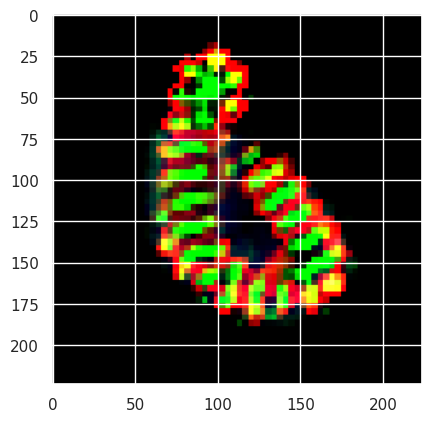

In [46]:
from models.models_lenia import Lenia
rng = jax.random.PRNGKey(0)
vids = []
sim = Lenia(grid_size=512, center_phenotype=True, phenotype_size=64, start_pattern="5N7KKM", clip1=1.)
# sim = create_sim('lenia_1.0')
sim = FlattenSimulationParameters(sim)
rollout_fn = partial(rollout_and_embed_simulation, sim=sim, clip_model=None, rollout_steps=256, n_rollout_imgs='video')
rollout_fn = jax.jit(rollout_fn)

iprt = sim_iprts[0][4]
prompt = prompt_sweep[iprt]
print(prompt)
dfi = df[(df.sim=='lenia_1.0') & (df.iprt==iprt)]
dfi = dfi.loc[dfi['loss'].idxmin()]
rollout_data = rollout_fn(rng, dfi['params'])
vid = rollout_data['rgb']
plt.imshow(vid[-1])

In [87]:
from clip_jax import MyFlaxCLIP
clip_model = MyFlaxCLIP()

In [88]:
rng = jax.random.PRNGKey(0)
sim = create_sim('boids')
sim = FlattenSimulationParameters(sim)
rollout_fn = partial(rollout_and_embed_simulation, sim=sim, clip_model=clip_model, rollout_steps=sim.sim.rollout_steps, n_rollout_imgs='final')
rollout_fn = jax.jit(rollout_fn)

dfi = df[(df.sim=='boids') & (df.iprt==0)]
dfi = dfi.loc[dfi['loss'].idxmin()]
p1 = dfi.params
dfi = df[(df.sim=='boids') & (df.iprt==23)]
dfi = dfi.loc[dfi['loss'].idxmin()]
p2 = dfi.params

ParameterReshaper: 193 parameters detected for optimization.


In [89]:
ts = jnp.linspace(0, 1, 201)
params = p1 + (p2-p1)*ts[:, None]
params = params.at[0].set(p1)
params = params.at[-1].set(p2)
rollout_data = [rollout_fn(rng, p) for p in tqdm(params)]
rollout_data = jax.tree.map(lambda *x: jnp.stack(x), *rollout_data)

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

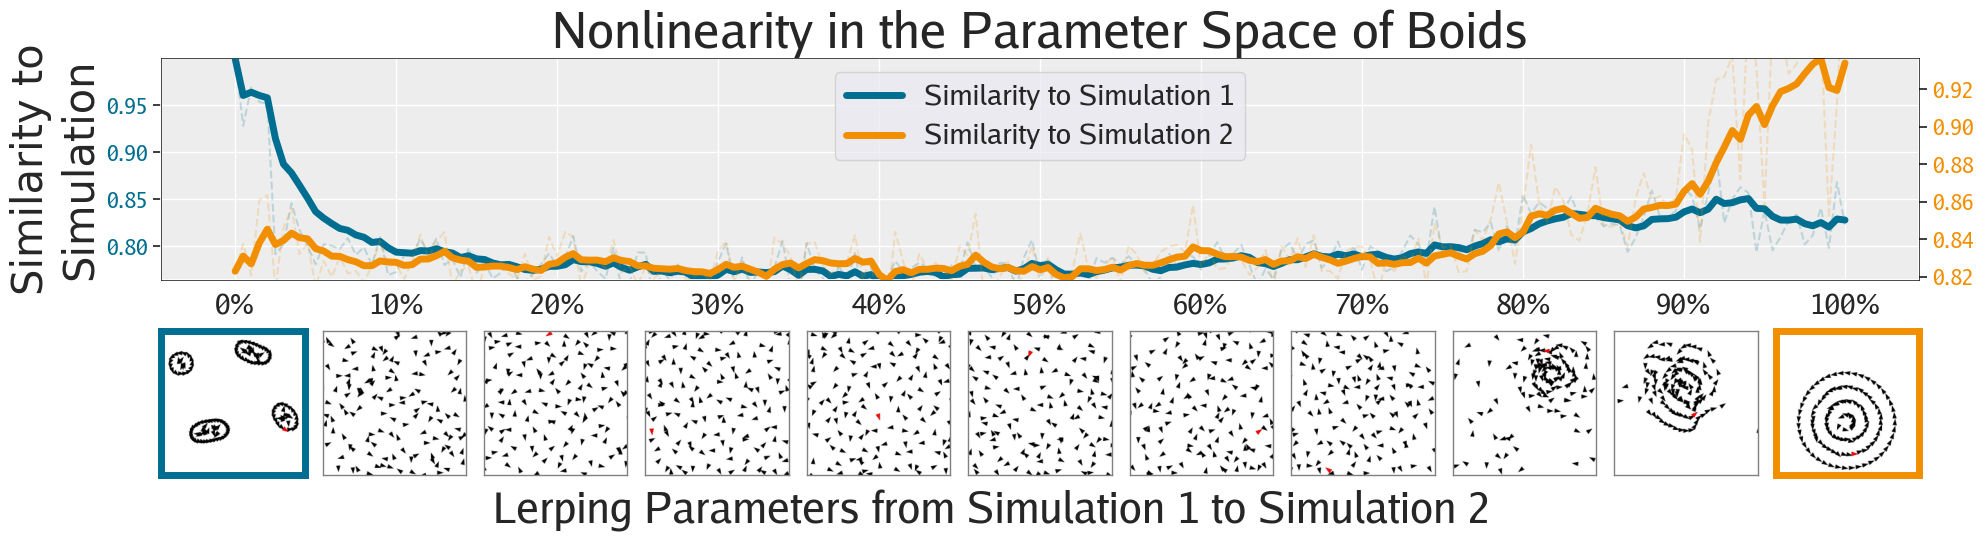

In [90]:
fig = plt.figure(figsize=(20, 6))
gs = fig.add_gridspec(2, 11)
# col1, col2 = '#007800', '#780000'
col1, col2 = '#006e90', '#f18f01'


# Create the single plot for the first row
ax_top = fig.add_subplot(gs[0, :])
plt.sca(ax_top)
# plt.plot(ts, z@z[-1])
z = rollout_data['z']
y1 = (z@z[0])
y2 = (z@z[-1])
y1_smooth = np.array(pd.DataFrame(y1).ewm(span=10).mean())
y2_smooth = np.array(pd.DataFrame(y2).ewm(span=10).mean())
plt.plot(ts, y1, alpha=0.2, color=col1, linestyle='--')
plt.plot(ts, y1_smooth, color=col1, linewidth=5, label="Similarity to Simulation 1")
plt.ylim(y1_smooth.min(), y1_smooth.max())
# plt.ylabel("Similarity to\nSimulation 1", fontsize=25, fontname='Go', color='#007800')
plt.yticks(fontsize=15, fontname='Go', color=col1)
plt.xticks(np.linspace(0, 1, 11), [f"{t*100:.0f}%" for t in np.linspace(0, 1, 11).round(1)], fontsize=20, fontname='Go')
plt.xlim(-0.046, 1.046)
plt.ylabel("Similarity to\nSimulation", fontsize=30)

plt.gca().set_facecolor("#ededed")
plt.grid(color='white')

lines, labels = plt.gca().get_legend_handles_labels()

plt.twinx()
plt.plot(ts, y2, alpha=0.2, color=col2, linestyle='--')
plt.plot(ts, y2_smooth, color=col2, linewidth=5, label="Similarity to Simulation 2")
plt.ylim(y2_smooth.min(), y2_smooth.max())
plt.yticks(fontsize=15, fontname='Go', color=col2)

plt.gca().set_facecolor("#ededed")
plt.grid(False)
[plt.gca().spines[i].set_color('black') for i in ['top', 'bottom', 'left', 'right']]
[plt.gca().spines[i].set_linewidth(0.5) for i in ['top', 'bottom', 'left', 'right']]

lines2, labels2 = plt.gca().get_legend_handles_labels()
legend = plt.legend(lines + lines2, labels + labels2, prop={'family': 'Go', 'size': 20}, loc='upper center')
# legend.set_title("Similarity to Simulation", prop={'family': 'Go', 'size': 20})

plt.title("Nonlinearity in the Parameter Space of Boids", fontsize=35, fontname='Go')

for i, t in enumerate(tqdm(np.linspace(0, 1, 11))):
    ax = fig.add_subplot(gs[1, i])
    plt.sca(ax)
    img = rollout_data['rgb'][i*20]
    # img = jnp.pad(img, ((2, 1), (1, 1), (0, 0)), mode='constant', constant_values=0.5)
    plt.imshow(img)
    plt.grid(False)
    plt.xticks([]); plt.yticks([])
    for spine in plt.gca().spines.values():

        if i==0:
            spine.set_edgecolor(col1)
            spine.set_linewidth(5)
        elif i==10:
            spine.set_edgecolor(col2)
            spine.set_linewidth(5)
        else:
            spine.set_edgecolor((0.5, 0.5, 0.5, 1.))
            spine.set_linewidth(1)

fig.supxlabel("Lerping Parameters from Simulation 1 to Simulation 2", y=0.1, fontsize=30, fontname='Go')
plt.tight_layout()

plt.savefig("/home/akarsh_sakana_ai/nca-alife-data/figs_final/lerp_boids.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.savefig("/home/akarsh_sakana_ai/nca-alife-data/figs_final/lerp_boids.png", format='png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
rng = jax.random.PRNGKey(0)
sim = create_sim('plife_ba')
sim = FlattenSimulationParameters(sim)
rollout_fn = partial(rollout_and_embed_simulation, sim=sim, clip_model=clip_model, rollout_steps=sim.sim.rollout_steps, n_rollout_imgs='final')
rollout_fn = jax.jit(rollout_fn)

dfi = df[(df.sim=='plife_ba') & (df.iprt==29)]
dfi = dfi.loc[dfi['loss'].idxmin()]
p1 = dfi.params

ParameterReshaper: 42 parameters detected for optimization.


In [ ]:
from models.models_plife import ParticleLife
# n_particle_sweep = np.logspace(np.log10(30), np.log10(30000), 20).astype(int)
n_particle_sweep = [30, 100, 300, 1000, 3000, 10000, 30000]
rollout_data = []
for n_particles in tqdm(n_particle_sweep):
    sim = ParticleLife(n_particles=n_particles, n_colors=6, search_space="beta+alpha", dt=2e-3, render_radius=1e-2)  
    sim = FlattenSimulationParameters(sim)
    rollout_fn = partial(rollout_and_embed_simulation, sim=sim, clip_model=clip_model, rollout_steps=1000, n_rollout_imgs='final')
    rollout_data.append(rollout_fn(rng, p1))
rollout_data = jax.tree.map(lambda *x: jnp.stack(x), *rollout_data)

  0%|          | 0/7 [00:00<?, ?it/s]

ParameterReshaper: 42 parameters detected for optimization.
ParameterReshaper: 42 parameters detected for optimization.
ParameterReshaper: 42 parameters detected for optimization.
ParameterReshaper: 42 parameters detected for optimization.
ParameterReshaper: 42 parameters detected for optimization.
ParameterReshaper: 42 parameters detected for optimization.
ParameterReshaper: 42 parameters detected for optimization.


In [ ]:
z_text = clip_model.embed_text(["a caterpillar"])[0]

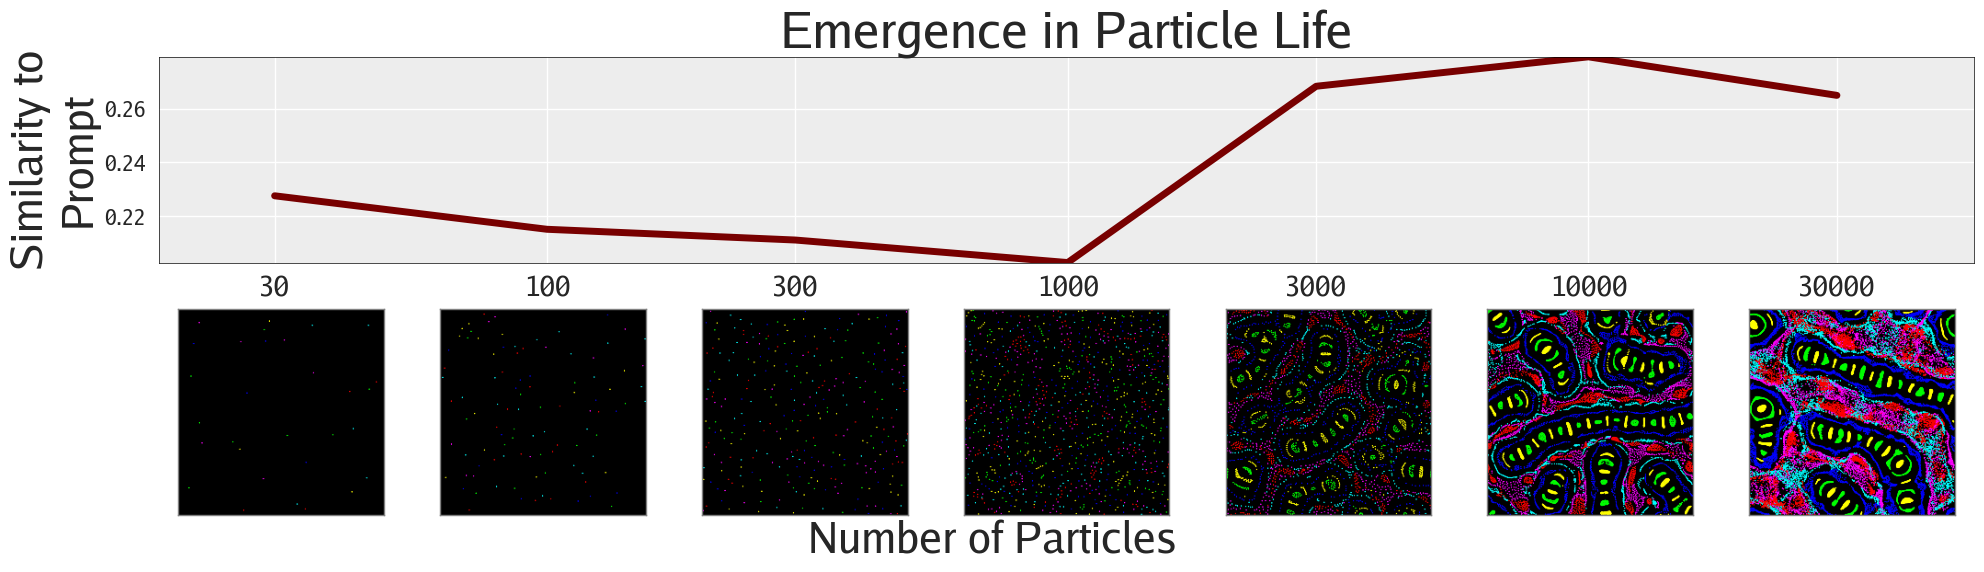

In [ ]:
fig = plt.figure(figsize=(20, 6))
gs = fig.add_gridspec(2, 7)

ax_top = fig.add_subplot(gs[0, :])
plt.sca(ax_top)
z = rollout_data['z']
a = (z@z_text)
y = np.array(pd.DataFrame(a).ewm(span=1).mean())
plt.plot(n_particle_sweep, y, alpha=1.0, color='#780000', linewidth=5)
plt.ylim(y.min(), y.max())
plt.ylabel("Similarity to\nPrompt", fontsize=30, fontname='Go')
plt.yticks(fontsize=15, fontname='Go')
plt.xscale('log')
plt.xticks(n_particle_sweep, [f"{n}" for n in n_particle_sweep], fontsize=20, fontname='Go')
plt.xlim(18, 55000)

plt.gca().set_facecolor("#ededed")
plt.grid(color='white')
[plt.gca().spines[i].set_color('black') for i in ['top', 'bottom', 'left', 'right']]
[plt.gca().spines[i].set_linewidth(0.5) for i in ['top', 'bottom', 'left', 'right']]

plt.title("Emergence in Particle Life", fontsize=35, fontname='Go')

for i in range(7):
    ax = fig.add_subplot(gs[1, i])
    plt.sca(ax)
    img = rollout_data['rgb'][i]
    plt.imshow(img)
    plt.grid(False)
    plt.xticks([]); plt.yticks([])
    for spine in plt.gca().spines.values():
        spine.set_edgecolor((0.5, 0.5, 0.5, 1.))
        spine.set_linewidth(1)

fig.supxlabel("Number of Particles", y=0.05, fontsize=30, fontname='Go')
plt.tight_layout()

plt.savefig("/home/akarsh_sakana_ai/nca-alife-data/figs/lerp_plife.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.show()


In [91]:
rng = jax.random.PRNGKey(0)
sim = create_sim('lenia_1.0')
sim = FlattenSimulationParameters(sim)
rollout_fn = partial(rollout_and_embed_simulation, sim=sim, clip_model=clip_model, rollout_steps=sim.sim.rollout_steps, n_rollout_imgs='video')
rollout_fn = jax.jit(rollout_fn)

dfi = df[(df.sim=='lenia_1.0') & (df.iprt==17)]
dfi = dfi.loc[dfi['loss'].idxmin()]
p1 = dfi.params

ParameterReshaper: 3117 parameters detected for optimization.


In [92]:
rollout_data = rollout_fn(rng, p1)

Could not load symbol cuFuncGetName. Error: /lib/x86_64-linux-gnu/libcuda.so.1: undefined symbol: cuFuncGetName


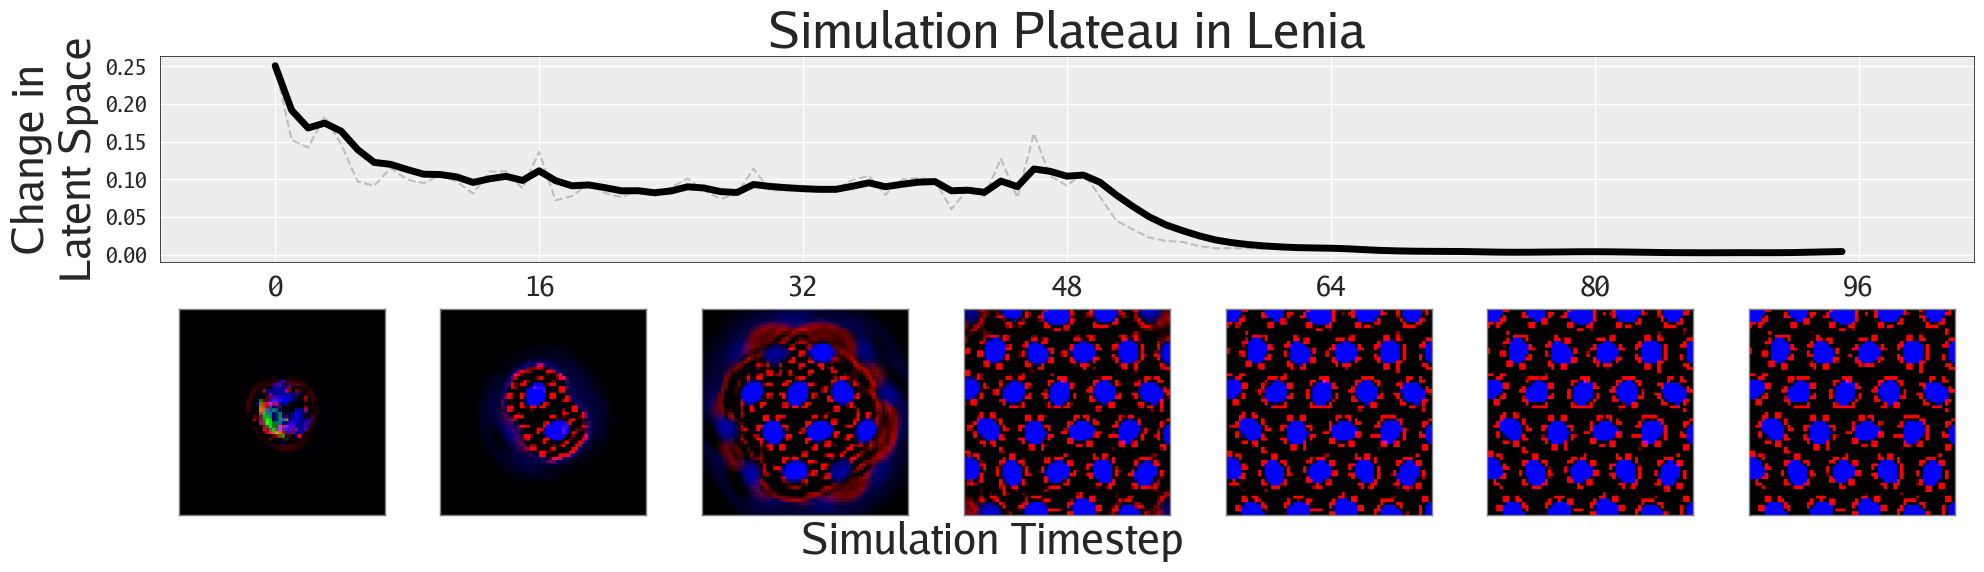

In [94]:
fig = plt.figure(figsize=(20, 6))
gs = fig.add_gridspec(2, 7)
ax_top = fig.add_subplot(gs[0, :])
plt.sca(ax_top)
z = rollout_data['z']
y = jnp.linalg.norm(jnp.diff(z, axis=0), axis=-1)
y = y[:96]

# z = rollout_data['z'][:96] # T D
# scores_novelty = (z @ z.T) # T T
# scores_novelty = jnp.tril(scores_novelty, k=-1)
# loss_novelty = scores_novelty.max(axis=-1) # T
# y = -loss_novelty[2:]


plt.plot(np.arange(len(y)), y, alpha=0.2, color='black', linestyle='--')
y = np.array(pd.DataFrame(y).ewm(span=5).mean())
plt.plot(np.arange(len(y)), y, alpha=1.0, color='black', linewidth=5)
# plt.ylim(y.min(), y.max())
plt.ylabel("Change in\nLatent Space", fontsize=30, fontname='Go')
plt.yticks(fontsize=15, fontname='Go')
# plt.xscale('log')
plt.xticks(np.arange(0, 97, 16), [f"{n}" for n in np.arange(0, 97, 16)], fontsize=20, fontname='Go')
plt.xlim(-7, 103)

plt.gca().set_facecolor("#ededed")
plt.grid(color='white')
[plt.gca().spines[i].set_color('black') for i in ['top', 'bottom', 'left', 'right']]
[plt.gca().spines[i].set_linewidth(0.5) for i in ['top', 'bottom', 'left', 'right']]

plt.title("Simulation Plateau in Lenia", fontsize=35, fontname='Go')

for i in range(7):
    ax = fig.add_subplot(gs[1, i])
    plt.sca(ax)
    img = rollout_data['rgb'][i*16]
    plt.imshow(img)
    plt.grid(False)
    plt.xticks([]); plt.yticks([])
    for spine in plt.gca().spines.values():
        spine.set_edgecolor((0.5, 0.5, 0.5, 1.))
        spine.set_linewidth(1)

fig.supxlabel("Simulation Timestep", y=0.05, fontsize=30, fontname='Go')

plt.tight_layout()

plt.savefig("/home/akarsh_sakana_ai/nca-alife-data/figs_final/lerp_lenia.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.savefig("/home/akarsh_sakana_ai/nca-alife-data/figs_final/lerp_lenia.png", format='png', dpi=300, bbox_inches='tight')
plt.show()


In [95]:
rng = jax.random.PRNGKey(0)
sim = create_sim('plife_ba')
sim = FlattenSimulationParameters(sim)
rollout_fn = partial(rollout_and_embed_simulation, sim=sim, clip_model=clip_model, rollout_steps=sim.sim.rollout_steps, n_rollout_imgs='final')
rollout_fn = jax.jit(rollout_fn)

dfi = df[(df.sim=='plife_ba') & (df.iprt==29)]
dfi = dfi.loc[dfi['loss'].idxmin()]
p1 = jnp.array(dfi.params)
z_text = clip_model.embed_text(["a caterpillar"])[0]

ParameterReshaper: 42 parameters detected for optimization.


In [96]:
rollout_data = []
for i in tqdm(range(len(p1))):
    for t in np.linspace(-1.5, 1.5, 10):
        p2 = p1.at[i].set(t)
        rollout_data.append(rollout_fn(rng, p2))
rollout_data = jax.tree.map(lambda *x: jnp.stack(x), *rollout_data)

  0%|          | 0/42 [00:00<?, ?it/s]

In [97]:
rollout_data = jax.tree.map(lambda x: rearrange(x, "(N T) ... -> N T ...", N=len(p1)), rollout_data)

In [98]:
z = rollout_data['z']
scores = (z@z_text)
scores.shape

(42, 10)

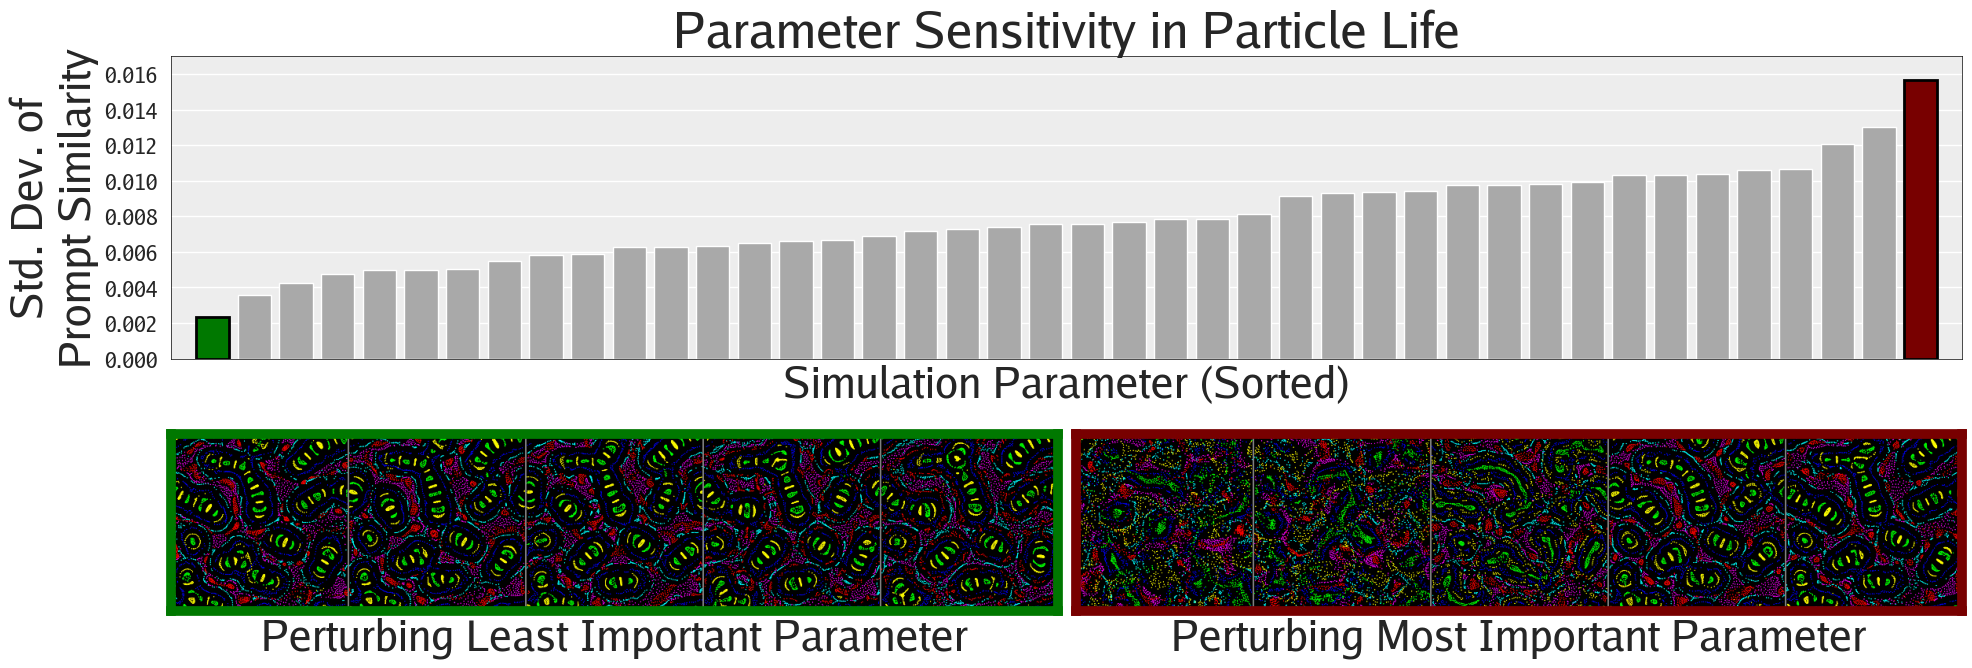

In [99]:
fig = plt.figure(figsize=(20, 7))
gs = fig.add_gridspec(2, 2)
ax = fig.add_subplot(gs[0, :])
plt.sca(ax)

a = scores.std(axis=-1)
a = np.sort(a)
n = len(a)
plt.bar(np.arange(n), a, color='darkgray')
# plt.xticks(np.arange(n), [f"{i}" for i in np.arange(n)], fontsize=20, fontname='Go')
plt.xticks([])
plt.yticks(fontsize=15, fontname='Go')
plt.ylim(0, 0.017)
plt.xlim(-1, n)

a = scores.std(axis=-1)
i1, i2 = a.argmax(), a.argmin()
plt.bar(0, a[i2], color='#007800', edgecolor='black', linewidth=2)
plt.bar(n-1, a[i1], color='#780000', edgecolor='black', linewidth=2)
plt.gca().set_facecolor("#ededed")
[plt.gca().spines[i].set_color('black') for i in ['top', 'bottom', 'left', 'right']]
[plt.gca().spines[i].set_linewidth(0.5) for i in ['top', 'bottom', 'left', 'right']]
plt.xlabel("Simulation Parameter (Sorted)", fontsize=30, fontname='Go')
plt.ylabel("Std. Dev. of\nPrompt Similarity", fontsize=30, fontname='Go')

plt.title("Parameter Sensitivity in Particle Life", fontsize=35, fontname='Go')

ax = fig.add_subplot(gs[1, 1])
plt.sca(ax)
img = rollout_data['rgb'][i1][::2]
img = jnp.pad(img, ((0, 0), (1, 1), (1, 1), (0, 0)), mode='constant', constant_values=0.5)
img = rearrange(img, "T H W D -> H (T W) D")
plt.imshow(img)
plt.grid(False)
plt.xticks([]); plt.yticks([])
[plt.gca().spines[i].set_color('#780000') for i in ['top', 'bottom', 'left', 'right']]
[plt.gca().spines[i].set_linewidth(7) for i in ['top', 'bottom', 'left', 'right']]
plt.xlabel(f"Perturbing Most Important Parameter", fontsize=30, fontname='Go')

ax = fig.add_subplot(gs[1, 0])
plt.sca(ax)
img = rollout_data['rgb'][i2][::2]
img = jnp.pad(img, ((0, 0), (1, 1), (1, 1), (0, 0)), mode='constant', constant_values=0.5)
img = rearrange(img, "T H W D -> H (T W) D")
plt.imshow(img)
plt.grid(False)
plt.xticks([]); plt.yticks([])
[plt.gca().spines[i].set_color('#007800') for i in ['top', 'bottom', 'left', 'right']]
[plt.gca().spines[i].set_linewidth(7) for i in ['top', 'bottom', 'left', 'right']]
plt.xlabel(f"Perturbing Least Important Parameter", fontsize=30, fontname='Go')

plt.tight_layout()
plt.savefig("/home/akarsh_sakana_ai/nca-alife-data/figs_final/lerp_plife_sens.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.savefig("/home/akarsh_sakana_ai/nca-alife-data/figs_final/lerp_plife_sens.png", format='png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
rng = jax.random.PRNGKey(0)
imgs = []
scores = []
for cfg in cfgs:
    sim = create_sim(cfg['sim'])
    sim = FlattenSimulationParameters(sim)
    rollout_fn = partial(rollout_and_embed_simulation, sim=sim, clip_model=None, rollout_steps=sim.sim.rollout_steps, n_rollout_imgs='final')
    rollout_fn = jax.jit(rollout_fn)

    params, score = util.load_pkl(cfg['save_dir'], 'best')

    rollout_data = rollout_fn(rng, params)
    img = rollout_data['rgb']
    imgs.append(img)
    scores.append(score)
scores = np.stack(scores)
imgs = jnp.stack(imgs)
scores = rearrange(scores, "(A B) ... -> A B ...", A=7)
imgs = rearrange(imgs, "(A B) ... -> A B ...", A=7)
imgs.shape

ParameterReshaper: 2 parameters detected for optimization.
ParameterReshaper: 6 parameters detected for optimization.
ParameterReshaper: 12 parameters detected for optimization.
ParameterReshaper: 20 parameters detected for optimization.
ParameterReshaper: 30 parameters detected for optimization.
ParameterReshaper: 42 parameters detected for optimization.
ParameterReshaper: 2 parameters detected for optimization.
ParameterReshaper: 6 parameters detected for optimization.
ParameterReshaper: 12 parameters detected for optimization.
ParameterReshaper: 20 parameters detected for optimization.
ParameterReshaper: 30 parameters detected for optimization.
ParameterReshaper: 42 parameters detected for optimization.
ParameterReshaper: 2 parameters detected for optimization.
ParameterReshaper: 6 parameters detected for optimization.
ParameterReshaper: 12 parameters detected for optimization.
ParameterReshaper: 20 parameters detected for optimization.
ParameterReshaper: 30 parameters detected for 

KeyboardInterrupt: 

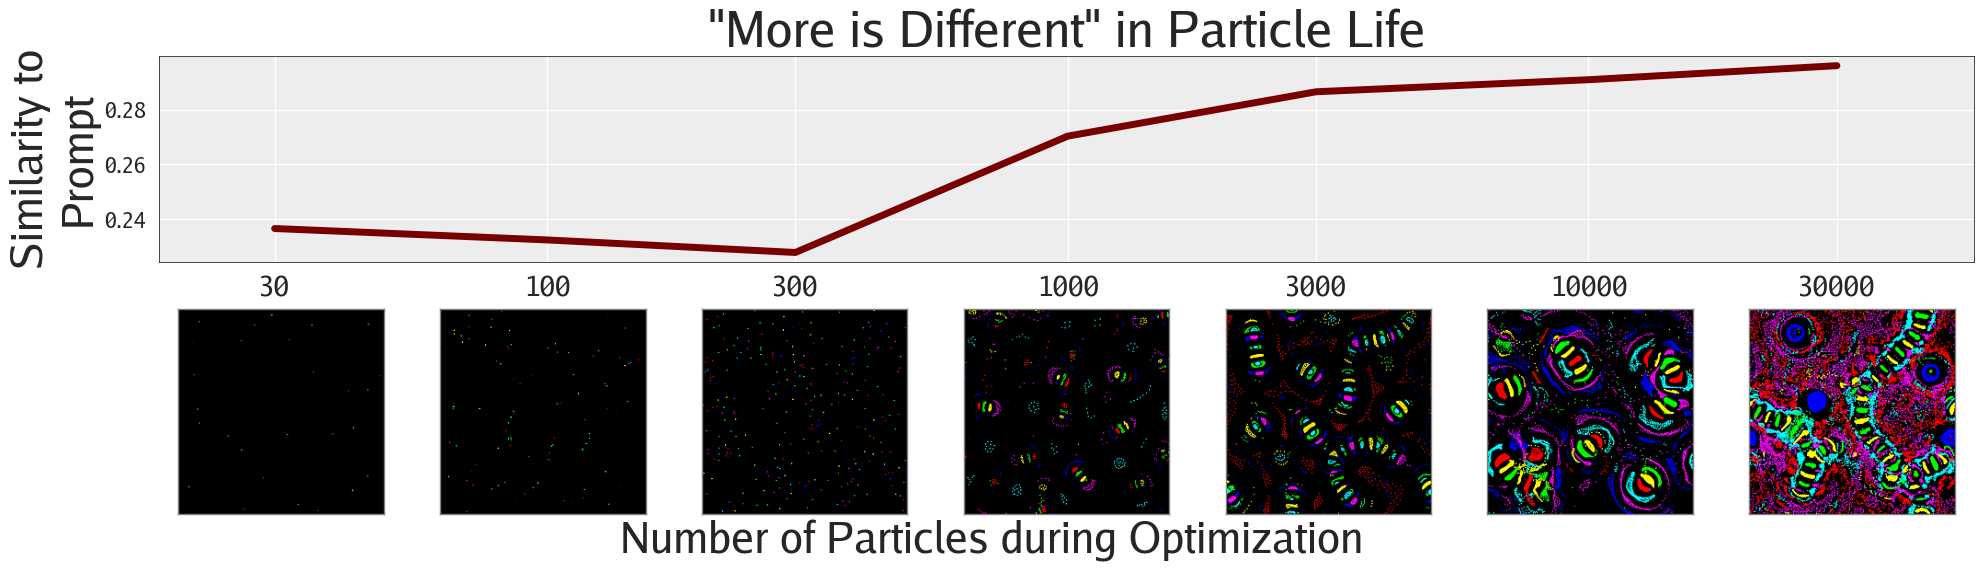

In [ ]:
fig = plt.figure(figsize=(20, 6))
gs = fig.add_gridspec(2, 7)

n_particle_sweep = [30, 100, 300, 1000, 3000, 10000, 30000]
ax_top = fig.add_subplot(gs[0, :])
plt.sca(ax_top)
# z = rollout_data['z']
# a = (z@z_text)
# y = np.array(pd.DataFrame(a).ewm(span=1).mean())
y = -scores.mean(axis=-1)
plt.plot(n_particle_sweep, y, alpha=1.0, color='black', linewidth=5)
# plt.ylim(y.min()-0.05*(y.max()-y.min()), y.max()+0.05*(y.max()-y.min()))
plt.ylabel("Similarity to\nPrompt", fontsize=30, fontname='Go')
plt.yticks(fontsize=15, fontname='Go')
plt.xscale('log')
plt.xticks(n_particle_sweep, [f"{n}" for n in n_particle_sweep], fontsize=20, fontname='Go')
plt.xlim(18, 55000)

plt.gca().set_facecolor("#ededed")
plt.grid(color='white')
[plt.gca().spines[i].set_color('black') for i in ['top', 'bottom', 'left', 'right']]
[plt.gca().spines[i].set_linewidth(0.5) for i in ['top', 'bottom', 'left', 'right']]

plt.title("\"More is Different\" in Particle Life", fontsize=35, fontname='Go')

for i in range(7):
    ax = fig.add_subplot(gs[1, i])
    plt.sca(ax)
    img = imgs[i, 2]
    plt.imshow(img)
    plt.grid(False)
    plt.xticks([]); plt.yticks([])
    for spine in plt.gca().spines.values():
        spine.set_edgecolor((0.5, 0.5, 0.5, 1.))
        spine.set_linewidth(1)

fig.supxlabel("Number of Particles during Optimization", y=0.05, fontsize=30, fontname='Go')
plt.tight_layout()

plt.savefig("/home/akarsh_sakana_ai/nca-alife-data/figs/lerp_plife_opt.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.show()


In [80]:

df = []
for cfg in tqdm(cfgs_plife_sweep):
    try:
        save_dir = cfg['save_dir']
        dfi = copy.copy(cfg)
        params, loss = util.load_pkl(save_dir, "best")
        dfi['loss'] = loss.item()
        dfi['params'] = params
        df.append(dfi)
    except Exception as e:
        print(e)
        break
df = pd.DataFrame(df)

  0%|          | 0/144 [00:00<?, ?it/s]

In [81]:
loss = -np.array(df['loss'])
loss = loss.reshape(4, 6, 6).mean(axis=0).T

In [100]:
rng = jax.random.PRNGKey(0)
imgs = []
scores = []
for i, cfg in enumerate(tqdm(cfgs_plife_sweep)):
    sim = create_sim(cfg['sim'])
    sim = FlattenSimulationParameters(sim)
    rollout_fn = partial(rollout_and_embed_simulation, sim=sim, clip_model=None, rollout_steps=sim.sim.rollout_steps, n_rollout_imgs='final')
    rollout_fn = jax.jit(rollout_fn)

    params, score = util.load_pkl(cfg['save_dir'], 'best')

    rollout_data = rollout_fn(rng, params)
    img = rollout_data['rgb']
    imgs.append(img)
    scores.append(score)

# scores = np.stack(scores)
# imgs = jnp.stack(imgs)
# scores = rearrange(scores, "(A B) ... -> A B ...", A=7)
# imgs = rearrange(imgs, "(A B) ... -> A B ...", A=7)
# imgs.shape

  0%|          | 0/144 [00:00<?, ?it/s]

ParameterReshaper: 2 parameters detected for optimization.
ParameterReshaper: 6 parameters detected for optimization.
ParameterReshaper: 12 parameters detected for optimization.
ParameterReshaper: 20 parameters detected for optimization.
ParameterReshaper: 30 parameters detected for optimization.
ParameterReshaper: 42 parameters detected for optimization.
ParameterReshaper: 2 parameters detected for optimization.
ParameterReshaper: 6 parameters detected for optimization.
ParameterReshaper: 12 parameters detected for optimization.
ParameterReshaper: 20 parameters detected for optimization.
ParameterReshaper: 30 parameters detected for optimization.
ParameterReshaper: 42 parameters detected for optimization.
ParameterReshaper: 2 parameters detected for optimization.
ParameterReshaper: 6 parameters detected for optimization.
ParameterReshaper: 12 parameters detected for optimization.
ParameterReshaper: 20 parameters detected for optimization.
ParameterReshaper: 30 parameters detected for 

In [101]:
scores = np.stack(scores)
imgs = np.stack(imgs)

In [102]:
imgs = imgs.reshape(4, 6, 6, 224, 224, 3)
scores = scores.reshape(4, 6, 6) # seed, N, K
imgs.shape, scores.shape

((4, 6, 6, 224, 224, 3), (4, 6, 6))

In [ ]:

y = -scores.mean(axis=-1)
plt.plot(n_particle_sweep, y, alpha=1.0, color='black', linewidth=5)
# plt.ylim(y.min()-0.05*(y.max()-y.min()), y.max()+0.05*(y.max()-y.min()))
plt.ylabel("Similarity to\nPrompt", fontsize=30, fontname='Go')
plt.yticks(fontsize=15, fontname='Go')
plt.xscale('log')
plt.xticks(n_particle_sweep, [f"{n}" for n in n_particle_sweep], fontsize=20, fontname='Go')
plt.xlim(18, 55000)

plt.gca().set_facecolor("#ededed")
plt.grid(color='white')
[plt.gca().spines[i].set_color('black') for i in ['top', 'bottom', 'left', 'right']]
[plt.gca().spines[i].set_linewidth(0.5) for i in ['top', 'bottom', 'left', 'right']]

plt.title("\"More is Different\" in Particle Life", fontsize=35, fontname='Go')

for i in range(7):
    ax = fig.add_subplot(gs[1, i])
    plt.sca(ax)
    img = imgs[i, 2]
    plt.imshow(img)
    plt.grid(False)
    plt.xticks([]); plt.yticks([])
    for spine in plt.gca().spines.values():
        spine.set_edgecolor((0.5, 0.5, 0.5, 1.))
        spine.set_linewidth(1)

fig.supxlabel("Number of Particles during Optimization", y=0.05, fontsize=30, fontname='Go')
plt.tight_layout()

plt.savefig("/home/akarsh_sakana_ai/nca-alife-data/figs/lerp_plife_opt.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.show()


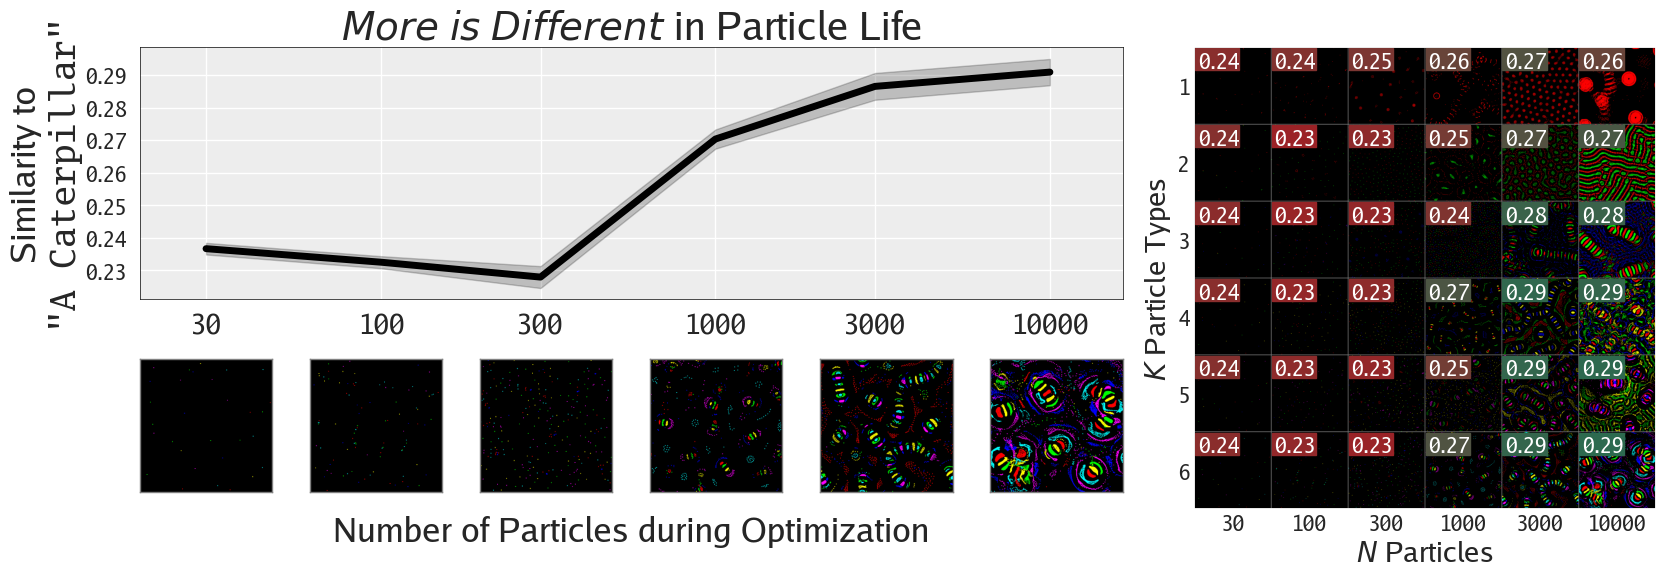

In [108]:
fig = plt.figure(figsize=(20, 6))
gs = fig.add_gridspec(2, 7, width_ratios=[1.]*6+[4.], height_ratios=[1.5, 1.])

n_particle_sweep = [30, 100, 300, 1000, 3000, 10000]
k_type_sweep = [1, 2, 3, 4, 5, 6]

seed = 2

ax = fig.add_subplot(gs[0, :6])
plt.sca(ax)
y = -scores.mean(axis=0)[:, -1]
plt.plot(n_particle_sweep, y, alpha=1.0, color='black', linewidth=5)

# highlight the std dev
y_mean = -scores.mean(axis=0)[:, -1]
y_std = scores.std(axis=0)[:, -1]
plt.fill_between(n_particle_sweep, y_mean-y_std, y_mean+y_std, color='black', alpha=0.2)


plt.ylabel("Similarity to\n", fontsize=30*.8, fontname='Go')
plt.text(-0.075, 0.5, "\"A Caterpillar\"", transform=plt.gca().transAxes, fontsize=25, fontname='Go Mono', rotation=90, va='center', ha='center')
plt.yticks(fontsize=15, fontname='Go')
plt.xscale('log')
plt.xticks(n_particle_sweep, [f"{n}" for n in n_particle_sweep], fontsize=20, fontname='Go')
# plt.xlim(18, 55000)
plt.xlim(19, 16500)

plt.gca().set_facecolor("#ededed")
plt.grid(color='white')
[plt.gca().spines[i].set_color('black') for i in ['top', 'bottom', 'left', 'right']]
[plt.gca().spines[i].set_linewidth(0.5) for i in ['top', 'bottom', 'left', 'right']]

plt.title("$\it{More}$ $\it{is}$ $\it{Different}$ in Particle Life", fontsize=35*.8, fontname='Go')

for i in range(6):
    ax = fig.add_subplot(gs[1, i])
    plt.sca(ax)
    img = imgs[seed, i, -1]
    plt.imshow(img)
    plt.grid(False)
    plt.xticks([]); plt.yticks([])
    for spine in plt.gca().spines.values():
        spine.set_edgecolor((0.5, 0.5, 0.5, 1.))
        spine.set_linewidth(1)
    
    # if i==0:
        # plt.ylabel("$K=6$", fontsize=20, fontname='Go')

ax = fig.add_subplot(gs[1, :6])
plt.sca(ax)
plt.xlabel("Number of Particles during Optimization", y=0.05, fontsize=30*.8, fontname='Go')
ax.patch.set_alpha(0)  # Make subplot background transparent
ax.set_xticks([])      # Remove x-ticks
ax.set_yticks([])      # Remove y-ticks
for spine in ax.spines.values():
    spine.set_alpha(0)  # Make all spines (borders) transparent

ax = fig.add_subplot(gs[:, 6:])
plt.sca(ax)

img = imgs[seed, :, ::]
img = jnp.pad(img, ((0, 0), (0, 0), (0, 2), (0, 2), (0, 0)), mode='constant', constant_values=0.5)
img = rearrange(img, "R C H W D -> (C H) (R W) D")
img = jnp.pad(img, ((2, 0), (2, 0), (0, 0)), mode='constant', constant_values=0.5)

plt.imshow(img)
plt.grid(False)
plt.xticks(np.arange(0, 226*6, 226) + 226/2., n_particle_sweep, fontsize=15, fontname='Go', y=0.02)
plt.yticks(np.arange(0, 226*6, 226) + 226/2., k_type_sweep, fontsize=15, fontname='Go', x=0.02)

from matplotlib import patches

from matplotlib.colors import Normalize, Colormap
from matplotlib.colors import LinearSegmentedColormap
# cmap = plt.get_cmap("bone")
# cmap = LinearSegmentedColormap.from_list('ak', ['#ef476f', '#06d6a0'], N=256)
cmap = LinearSegmentedColormap.from_list('ak', ['#9b2226', '#2d6a4f'], N=256)
norm = Normalize(vmin=(-scores.mean(axis=0)).min(), vmax=(-scores.mean(axis=0)).max())

for i in range(6): # loop over K
    for j in range(6): # loop over N
        # lossi = loss[i, j]
        lossi = -scores.mean(axis=0)[j, i]
        plt.text(j*226+10, i*226+10, f"{lossi:.2f}", fontsize=15, color='white', fontname='Go', ha='left', va='top')
        rect = patches.Rectangle((j*226+2, i*226+2), 130, 65, color=cmap(norm(lossi)))
        plt.gca().add_patch(rect)

plt.ylabel("$K$ Particle Types", fontsize=20, fontname='Go')
plt.xlabel("$N$ Particles", fontsize=20, fontname='Go')

# plt.ylabel("Similarity to\n ", fontsize=20, family="Go", labelpad=20)

# plt.tight_layout()
plt.savefig("/home/akarsh_sakana_ai/nca-alife-data/figs_final/lerp_plife_opt.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.savefig("/home/akarsh_sakana_ai/nca-alife-data/figs_final/lerp_plife_opt.png", format='png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
rng = jax.random.PRNGKey(0)
vids = []
for i_sim, sim_name in enumerate(sims_sweep):
    sim = create_sim(sim_name)
    sim = FlattenSimulationParameters(sim)
    rollout_fn = partial(rollout_simulation, sim=sim, img_size=128, rollout_steps=sim.sim.rollout_steps, n_rollout_imgs='video')
    rollout_fn = jax.jit(rollout_fn)

    for iprt, prompt in enumerate(tqdm(prompt_sweep)):
        if iprt not in sim_iprts[i_sim]:
            continue
        dfi = df[(df.sim==sim_name) & (df.iprt==iprt)]
        dfi = dfi.loc[dfi['loss'].idxmin()]
        rollout_data = rollout_fn(rng, dfi['params'])
        # print(rollout_data['rgb'].shape)
        vids.append(np.array(rollout_data['rgb']))
# imgs = jnp.stack(imgs).reshape(len(sims_sweep), len(prompt_sweep), 224, 224, 3)
# print(imgs.shape)

ParameterReshaper: 3117 parameters detected for optimization.


  0%|          | 0/46 [00:00<?, ?it/s]

ParameterReshaper: 193 parameters detected for optimization.


  0%|          | 0/46 [00:00<?, ?it/s]

ParameterReshaper: 42 parameters detected for optimization.


  0%|          | 0/46 [00:00<?, ?it/s]

In [ ]:
# vids[0].shape, vids[-1].shape
for i in range(len(vids)):
    vid = vids[i]
    if len(vid) < 1000:
        img = vid[-1]
        img = np.stack([img]*(1000-len(vid)))
        vid = np.concatenate([vid, img], axis=0)
        vids[i] = vid

In [ ]:
vids = np.stack(vids)
print(vids.shape)

(30, 1000, 128, 128, 3)


In [ ]:
vid = rearrange(vids, "(R C) T H W D -> T (R H) (C W) D", R=3, C=10)

In [ ]:
vid.shape

(1000, 384, 1280, 3)

In [ ]:
vid = np.array((vid*255).astype(np.uint8))

In [ ]:
imageio.mimwrite(f"/home/akarsh_sakana_ai/nca-alife-data/figs_vids/supervised.mp4", vid, fps=30, codec='libx264')

/home/akarsh_sakana_ai/miniconda3/envs/nca-alife-jax/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(


In [ ]:
import imageio

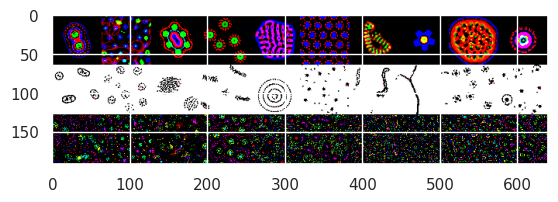

In [ ]:
plt.imshow(vid[-1])

In [ ]:
vid.shape

(1000, 192, 640, 3)

In [ ]:
from create_sim import create_sim
import evosax
from jax.random import split

def unroll_params(rng, params, sim, img_size=64, ret='vid'):
    def step(state, _rng):
        next_state = sim.step_state(_rng, state, params)
        return next_state, state
    state_init = sim.init_state(rng, params)
    state_final, state_vid = jax.lax.scan(step, state_init, split(rng, sim.rollout_steps))
    if ret=='vid':
        vid = jax.vmap(partial(sim.render_state, params=params, img_size=img_size))(state_vid)
        return vid
    elif ret=='img':
        img = sim.render_state(state_final, params=params, img_size=img_size)
        return img

In [ ]:
seed = 0
sigma = 0.1
coef_novelty = 0.
for sim_name, n_iters in zip(sims_sweep, n_iters_sweep):
    print(sim_name)
    sim = create_sim(sim_name)
    rng = jax.random.PRNGKey(0)
    param_reshaper = evosax.ParameterReshaper(sim.default_params(rng))

    plt.figure(figsize=(20, 10))
    for iprt, prompt in enumerate(tqdm(prompt_sweep)):
        save_dir=f"/home/akarsh_sakana_ai/nca-alife-data/main_opt/{seed}_{sim_name}_{iprt}_{sigma}_{coef_novelty}"

        params, _ = util.load_pkl(save_dir, 'best')
        params = param_reshaper.reshape_single(params)
        img = unroll_params(rng, params, sim, img_size=256, ret='img')
        plt.subplot(4, 8, iprt+1)
        plt.imshow(img)
        plt.grid(False)
        plt.title(prompt)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
seed = 0
sigma = 0.1
coef_novelty = 0.
for sim_name, n_iters in zip(sims_sweep, n_iters_sweep):
    for iprt, prompt in enumerate(prompt_sweep):
        save_dir=f"/home/akarsh_sakana_ai/nca-alife-data/main_opt/{seed}_{sim_name}_{iprt}_{sigma}_{coef_novelty}"
        data = util.load_pkl(save_dir, 'data')
        color = ['r', 'g', 'b', 'y', 'm', 'c', 'k', 'purple', 'orange'][sims_sweep.index(sim_name)]
        plt.plot(data['best_loss'], color=color, alpha=0.5, label=sim_name if iprt == 0 else "")
plt.xlabel('Iterations'); plt.ylabel('Best Loss')
plt.title('Loss Curves for Different Simulations and Prompts')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
def unroll_params(rng, params, sim, rollout_len=512, img_size=128, ret='vid'):
    def step(state, _rng):
        next_state = sim.step_state(_rng, state, params)
        return next_state, state
    state_init = sim.init_state(rng, params)
    state_final, state_vid = jax.lax.scan(step, state_init, split(rng, rollout_len))
    if ret=='vid':
        vid = jax.vmap(partial(sim.render_state, params=params, img_size=img_size))(state_vid)
        return vid
    elif ret=='img':
        img = sim.render_state(state_final, params=params, img_size=img_size)
        return img

In [ ]:
from create_sim import create_sim
sim_name = None
for cfg in cfgs[:1]:
    if sim_name is None or sim_name != cfg['sim']:
        sim_name = cfg['sim']
        sim = create_sim(cfg['sim'])
        unroll_fn = jax.jit(partial(unroll_params, sim=sim, rollout_len=sim.rollout_steps, img_size=128, ret='vid'))
    
    # unroll_fn(cfg[])

(array([-1.3907120e-01, -5.5725068e-02, -5.3500608e-03, -7.7292234e-01,
        -1.0215148e-01,  4.3550035e-01, -1.2078172e-01, -8.1291562e-01,
         1.9199310e-01,  1.1110213e+00,  7.0812583e-01,  1.0587292e+00,
        -1.7768556e-01,  7.5250983e-01, -1.0421708e+00, -5.9190845e-01,
         9.9746460e-01, -1.3373494e+00, -2.4140354e-01,  5.7246381e-01,
        -6.9753110e-01, -3.6157879e-01,  1.2048494e+00, -6.8600081e-02,
         5.5970424e-01,  7.9800159e-02,  1.1112787e+00, -1.1427866e-01,
         3.2938723e-02,  2.9171443e-01,  1.0095203e+00,  5.3387374e-01,
        -3.4883108e-02, -7.1899164e-01, -6.7817217e-01, -6.9385332e-01,
         7.6483667e-01,  1.6806908e-02,  2.0646590e-01,  1.9232227e-01,
         8.7041181e-01,  2.6317567e-01,  3.3361229e-01,  3.3676930e-02,
        -6.2710160e-01,  1.2156569e-01, -1.3024729e+00, -4.6158814e-01,
         4.8311853e-01, -3.6351919e-01, -1.4804748e+00,  5.1957268e-01,
         3.1182304e-01,  1.1822164e+00, -8.7982261e-01,  8.20923

In [ ]:
import imageio
import evosax
from create_sim import create_sim, unroll_params

In [ ]:
for sim_name, n_iters in zip(sims_sweep, n_iters_sweep):
    print(sim_name)
    sim = create_sim(sim_name)
    rng = jax.random.PRNGKey(0)
    param_reshaper = evosax.ParameterReshaper(sim.default_params(rng))

    unroll_fn = jax.jit(partial(unroll_params, sim=sim, rollout_len=sim.rollout_steps, img_size=64, ret='vid'))

    vid = []

    for coef_novelty in coef_novelty_sweep:
        for iprt, prompt in enumerate(prompt_sweep):
            # print(prompt)
            # cfg.update(sim=sim, seed=seed, prompts=prompt, sigma=sigma, coef_novelty=coef_novelty, n_iters=n_iters)
            save_dir=f"/home/akarsh_sakana_ai/nca-alife-data/main_opt_oe/{seed}_{sim_name}_{iprt}_{sigma}_{coef_novelty}"

            best = util.load_pkl(save_dir, 'best')
            params = param_reshaper.reshape_single(best[0])

            vid.append(unroll_fn(rng, params)[::2])

    vid = jnp.stack(vid)
    vid = jnp.pad(vid, ((0, 0), (0, 0), (1, 1), (1, 1), (0, 0)), mode='constant', constant_values=0.5)
    vid = np.array((vid*255).astype(jnp.uint8))
    vid = rearrange(vid, "(R C) T H W D -> T (R H) (C W) D", R=4, C=8)
    imageio.mimwrite(f"/home/akarsh_sakana_ai/nca-alife-data/main_opt_oe/{sim_name}.mp4", vid, fps=15, codec='libx264')
